In [633]:
library("brms")
library("dplyr")
library("bayesplot")
library("rstanarm")
library("ggplot2")
library("rstan")
library("tidyr")
library("ggpubr")
library("projpred")
library("corrplot")
library("loo")
library("tidyverse")
library("here")
library("knitr")
library("walker")
library("tidybayes")
library("broom")
library("ggridges")
library("cmdstanr")
library("reshape2")
library("lubridate")
library("hrbrthemes")
library("viridis")
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=12)

In [ ]:
#https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#using-or-publishing-our-price-paid-data
#     Postcode
#     PAON Primary Addressable Object Name. Typically the house number or name.
#     SAON Secondary Addressable Object Name. If there is a sub-building, for example, the building is divided into flats, there will be a SAON.
#     Street
#     Locality
#     Town/City
#     District
#     County

In [776]:
set_cmdstan_path("/Users/thomasmellan/Documents/cmdstan/")
path <- "/Users/thomasmellan/Documents/houseprices/"
df_hp_original <- read.csv(paste0(path,"pp-2020.csv"))

CmdStan path set to: /Users/thomasmellan/Documents/cmdstan



In [777]:
#df_hp <- head(df_hp_original,100)
df_hp <- df_hp_original
df_hp <- na.omit(df_hp)
colnames(df_hp) <- c("POAN","PricePaid","Date","Postcode",
                     "c1","c2","c3",
                     "a1","a2","a3","a4","a5","a6","a7",
                     "u1","u2")
# c1..3: some kind of code, to be googled
# a1..7: address parts
# u1..2: unknown, to be googled
df_hp$Date <- ymd(as.Date(df_hp$Date))

minPrice <- 100000  #100g
maxPrice <- 2000000 #2mil
df_hp <- df_hp[df_hp$PricePaid > minPrice & df_hp$PricePaid < maxPrice,]

df.gb <- df_hp
df.ldn <- df_hp[df_hp$a5 == "LONDON",]
head(df.tmp.ldn)

df.ldn$Month <- as.factor(month(df.ldn$Date))
df.ldn.tmp <- df.ldn[c("PricePaid","Month")]

POAN                                   PricePaid Date       Postcode c1 c2
867 {AE4D86D4-3CE1-4619-E053-6C04A8C03CD0} 710000    2020-07-24 NW1 7TJ  F  N 
870 {AE4D86D4-3CE4-4619-E053-6C04A8C03CD0} 340000    2020-07-24 N17 7PE  T  N 
871 {AE4D86D4-3CE5-4619-E053-6C04A8C03CD0} 192650    2020-07-10 N17 7PU  T  N 
872 {AE4D86D4-3CE7-4619-E053-6C04A8C03CD0} 920000    2020-05-20 N8 0PL   S  N 
875 {AE4D86D4-3CEA-4619-E053-6C04A8C03CD0} 479000    2020-07-24 NW6 6PY  F  N 
876 {AE4D86D4-3CEB-4619-E053-6C04A8C03CD0} 355000    2020-07-10 N12 8RF  F  N 
    c3 a1                   a2      a3                 a4      a5     a6      
867 L  GLOUCESTER COURT, 33 FLAT 6  GLOUCESTER AVENUE          LONDON CAMDEN  
870 F  165                          TOWER GARDENS ROAD         LONDON HARINGEY
871 F  27                           CHESTHUNTE ROAD            LONDON HARINGEY
872 F  25                           ALEXANDRA ROAD     HORNSEY LONDON HARINGEY
875 L  13A                          HAZELMERE ROAD             LONDON BRENT   
876 L  BEECHOLME            FLAT 13 WOODSIDE PARK ROAD         LONDON BARNET  
    a7             u1 u2
867 GREATER LONDON A  A 
870 GREATER LONDON A  A 
871 GREATER LONDON A  A 
872 GREATER LONDON A  A 
875 GREATER LONDON A  A 
876 GREATER LONDON A  A

In [778]:
summary(df.ldn[c("PricePaid","Date")])
summary(df.gb[c("PricePaid","Date")])

   PricePaid            Date           
 Min.   : 100500   Min.   :2020-01-02  
 1st Qu.: 380000   1st Qu.:2020-02-19  
 Median : 525000   Median :2020-04-03  
 Mean   : 631669   Mean   :2020-04-28  
 3rd Qu.: 775000   3rd Qu.:2020-07-10  
 Max.   :1999999   Max.   :2020-10-23  

   PricePaid            Date           
 Min.   : 100031   Min.   :2020-01-01  
 1st Qu.: 175000   1st Qu.:2020-02-21  
 Median : 255000   Median :2020-04-27  
 Mean   : 321701   Mean   :2020-05-04  
 3rd Qu.: 380000   3rd Qu.:2020-07-17  
 Max.   :1999999   Max.   :2020-10-29  

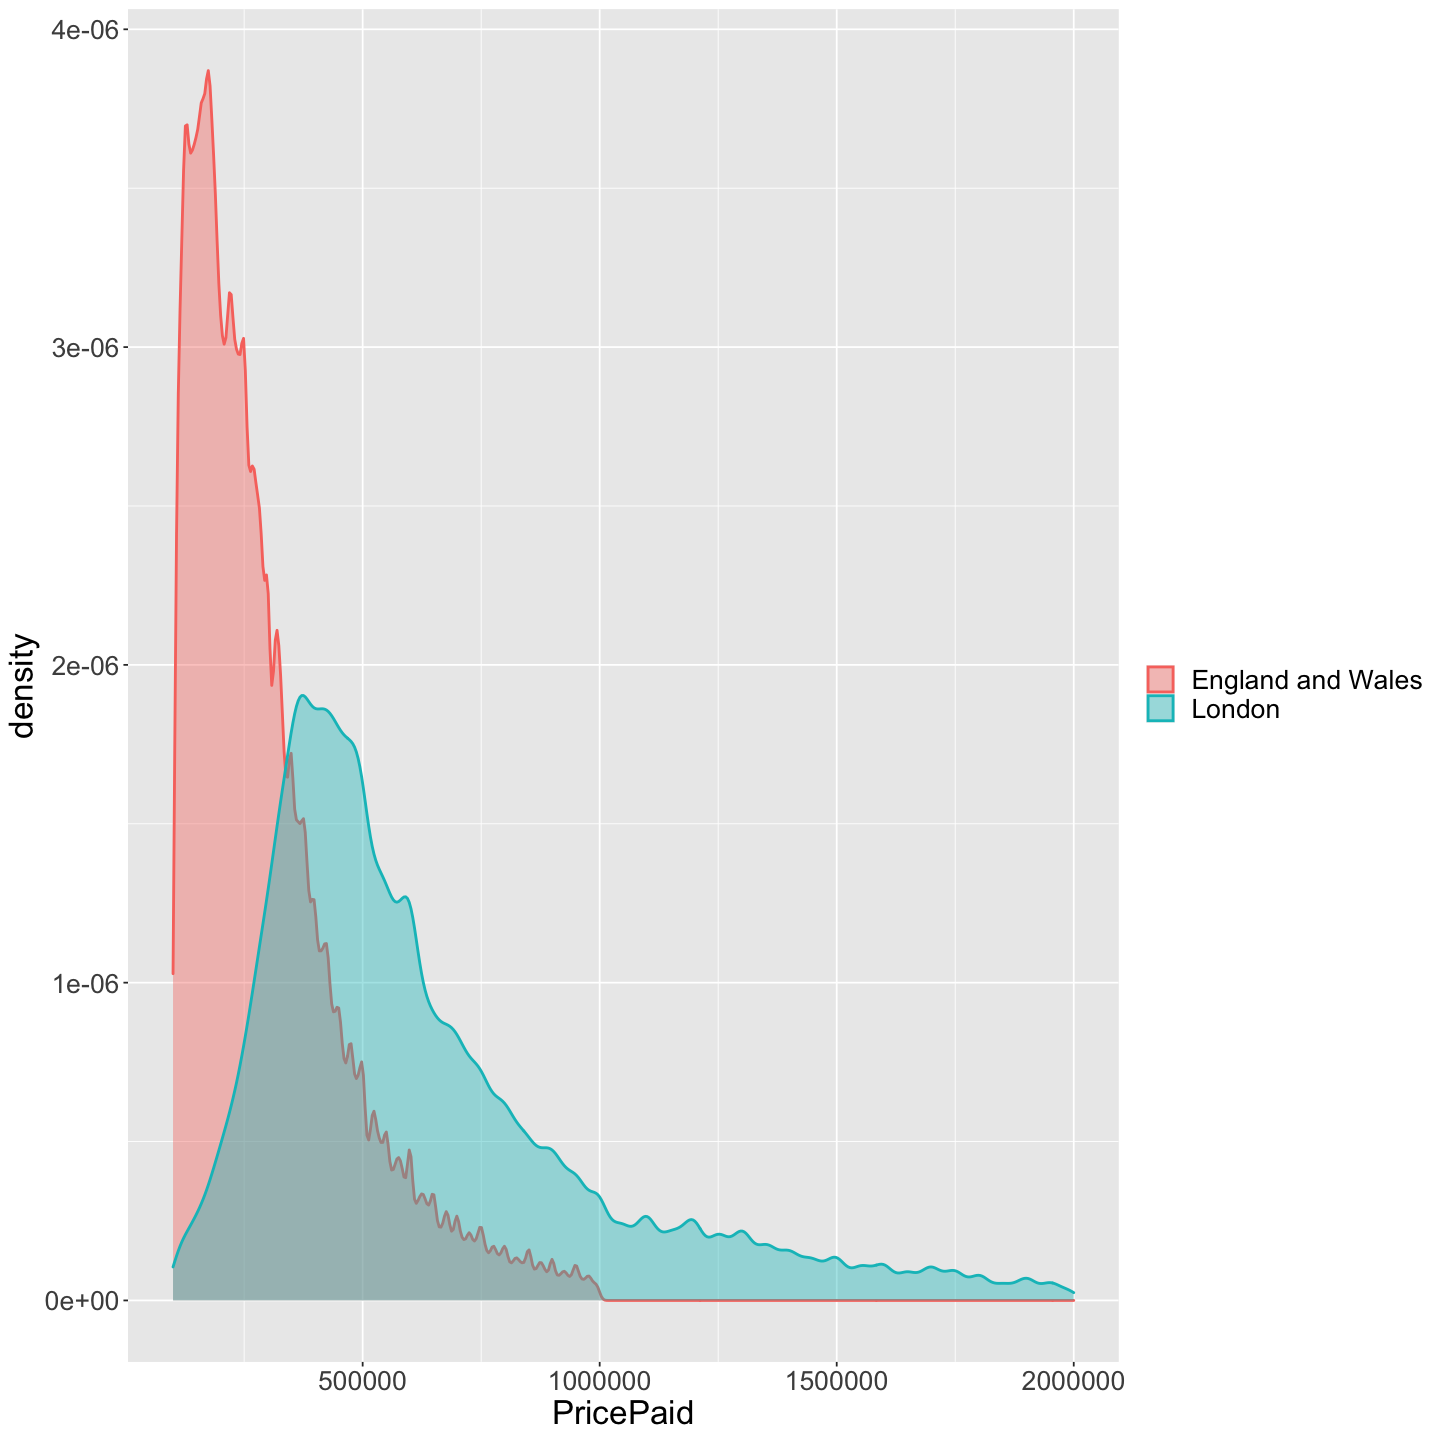

In [436]:
dat1 = data.frame(PricePaid = df.ldn$PricePaid, group="London")
dat2 = data.frame(PricePaid = df.gp$PricePaid, group="England and Wales")
dat = rbind(dat1, dat2)

ggplot(dat, aes(PricePaid, fill=group, colour=group)) +
    geom_density(alpha=0.4, lwd=0.8, adjust=0.5) + 
    theme(text = element_text(size = 20),legend.title = element_blank())

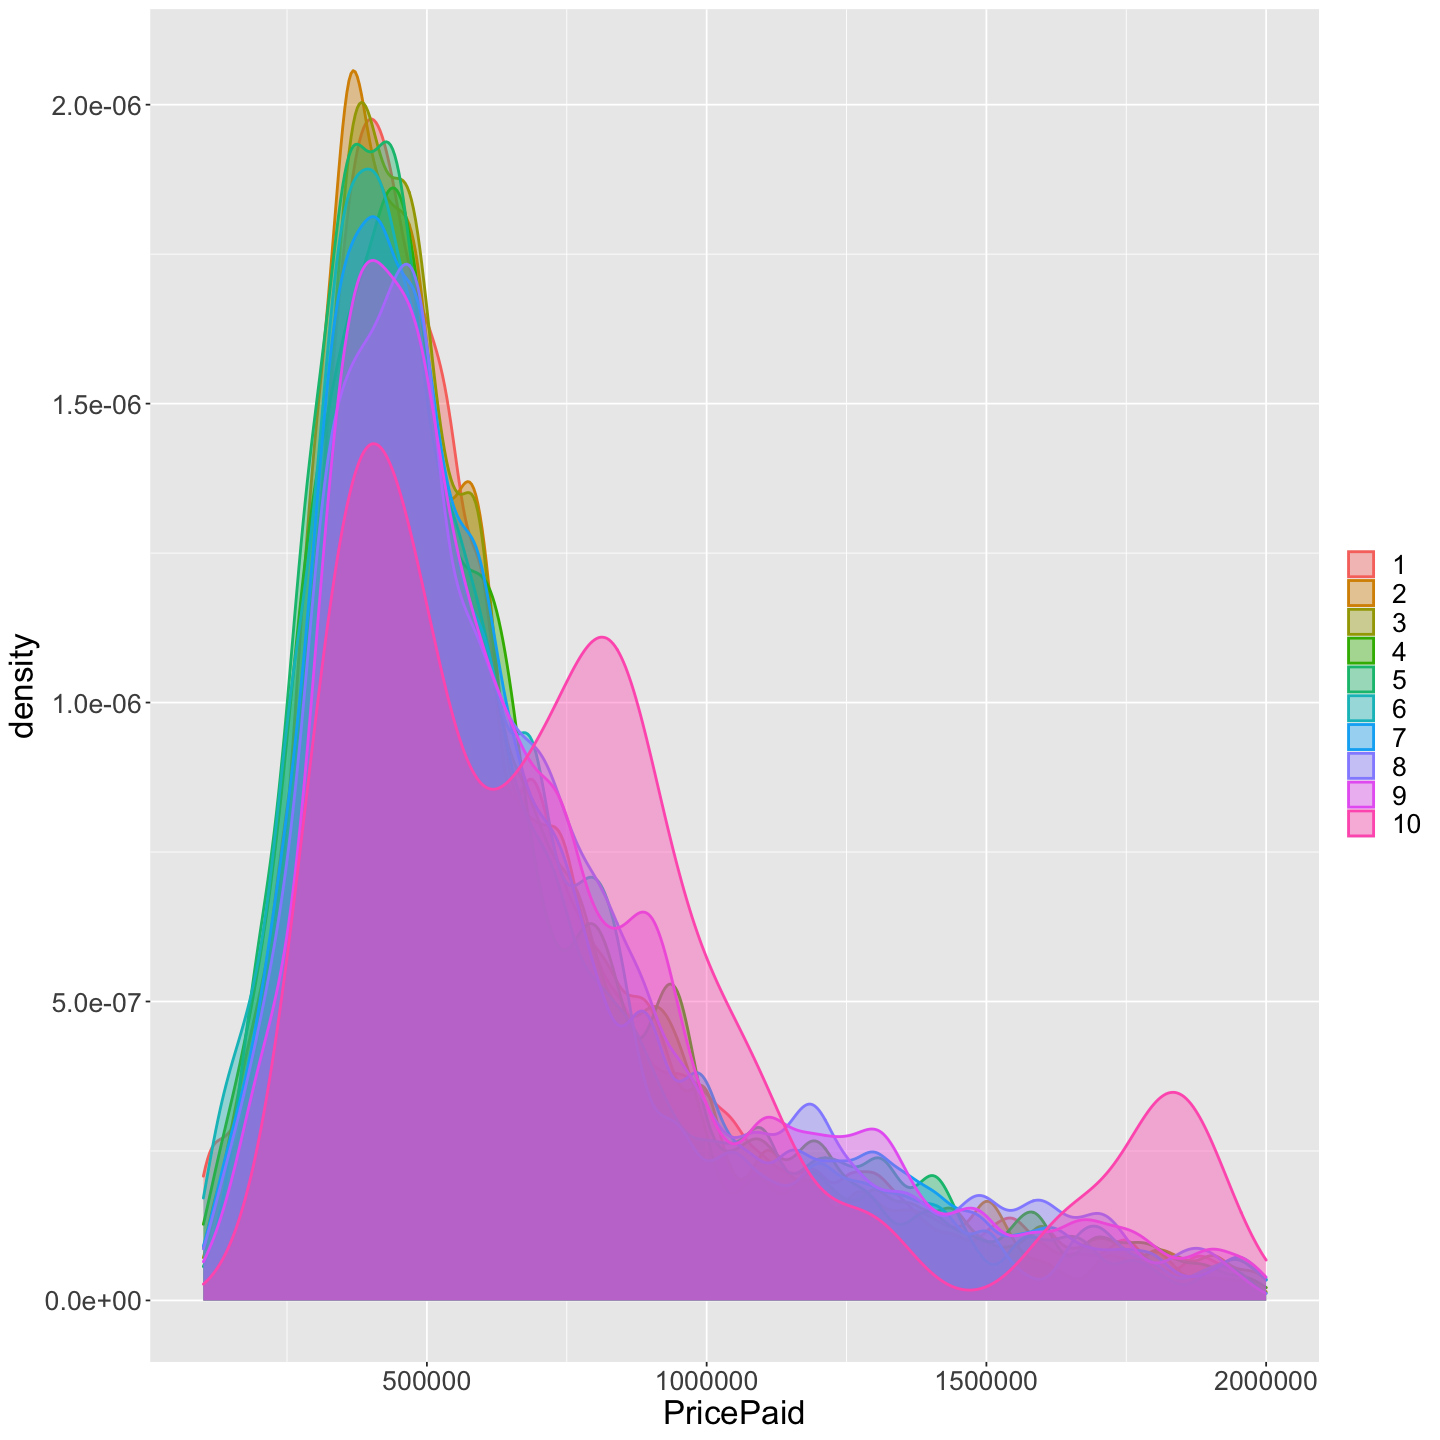

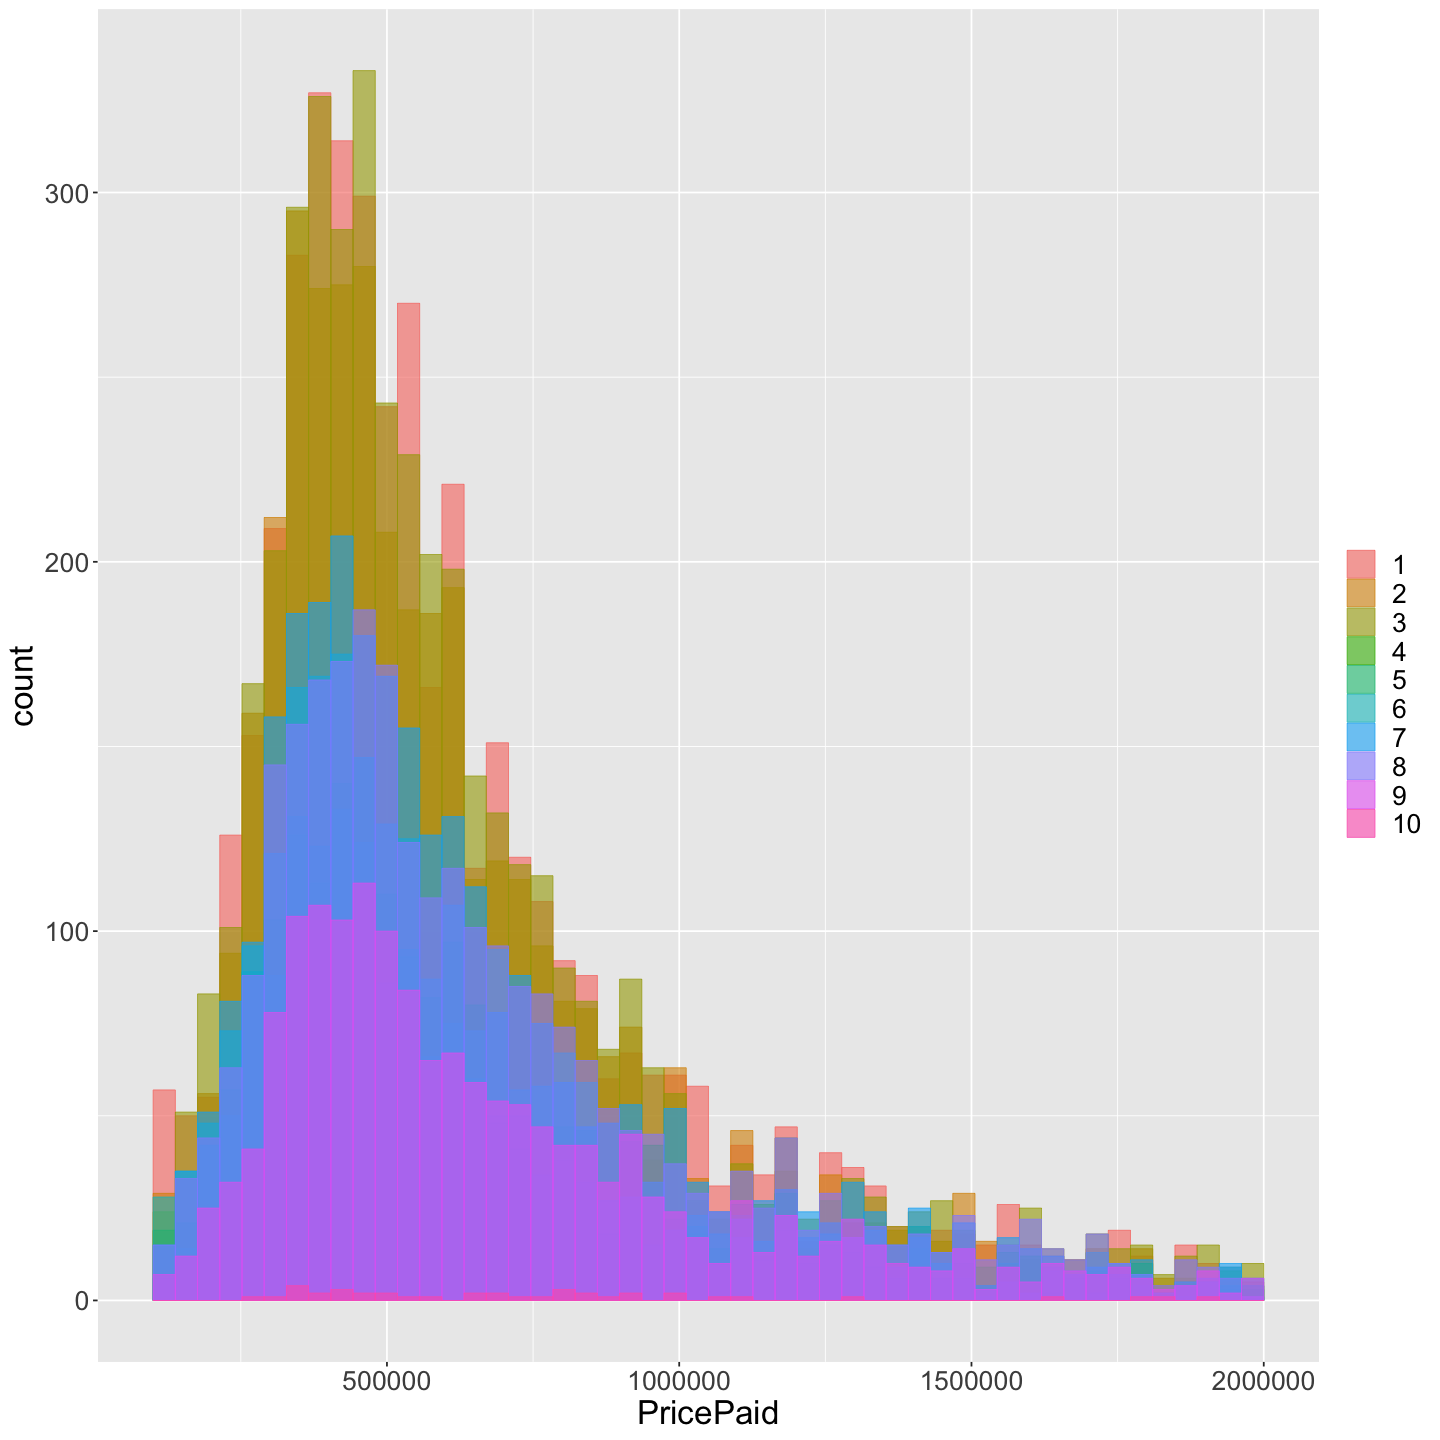

In [437]:
ggplot(df.ldn.tmp, aes(PricePaid, fill=Month, colour=Month)) +
    geom_density(alpha=0.4, lwd=0.8, adjust=0.5) +
    theme(text = element_text(size = 20),legend.title = element_blank())



ggplot(df.ldn.tmp, aes(PricePaid, fill=Month, colour=Month)) +
    geom_histogram(breaks=seq(minPrice,maxPrice,(maxPrice-minPrice)/50), alpha=0.6, 
                 position="identity", lwd=0.2) +
    theme(text = element_text(size = 20),legend.title = element_blank())

In [439]:
options(warn=-1)

In [440]:
df.ldn.tmp.f <- df.ldn.tmp
df.ldn.tmp.f$"Month" <- as.factor(df.ldn.tmp.f$"Month")

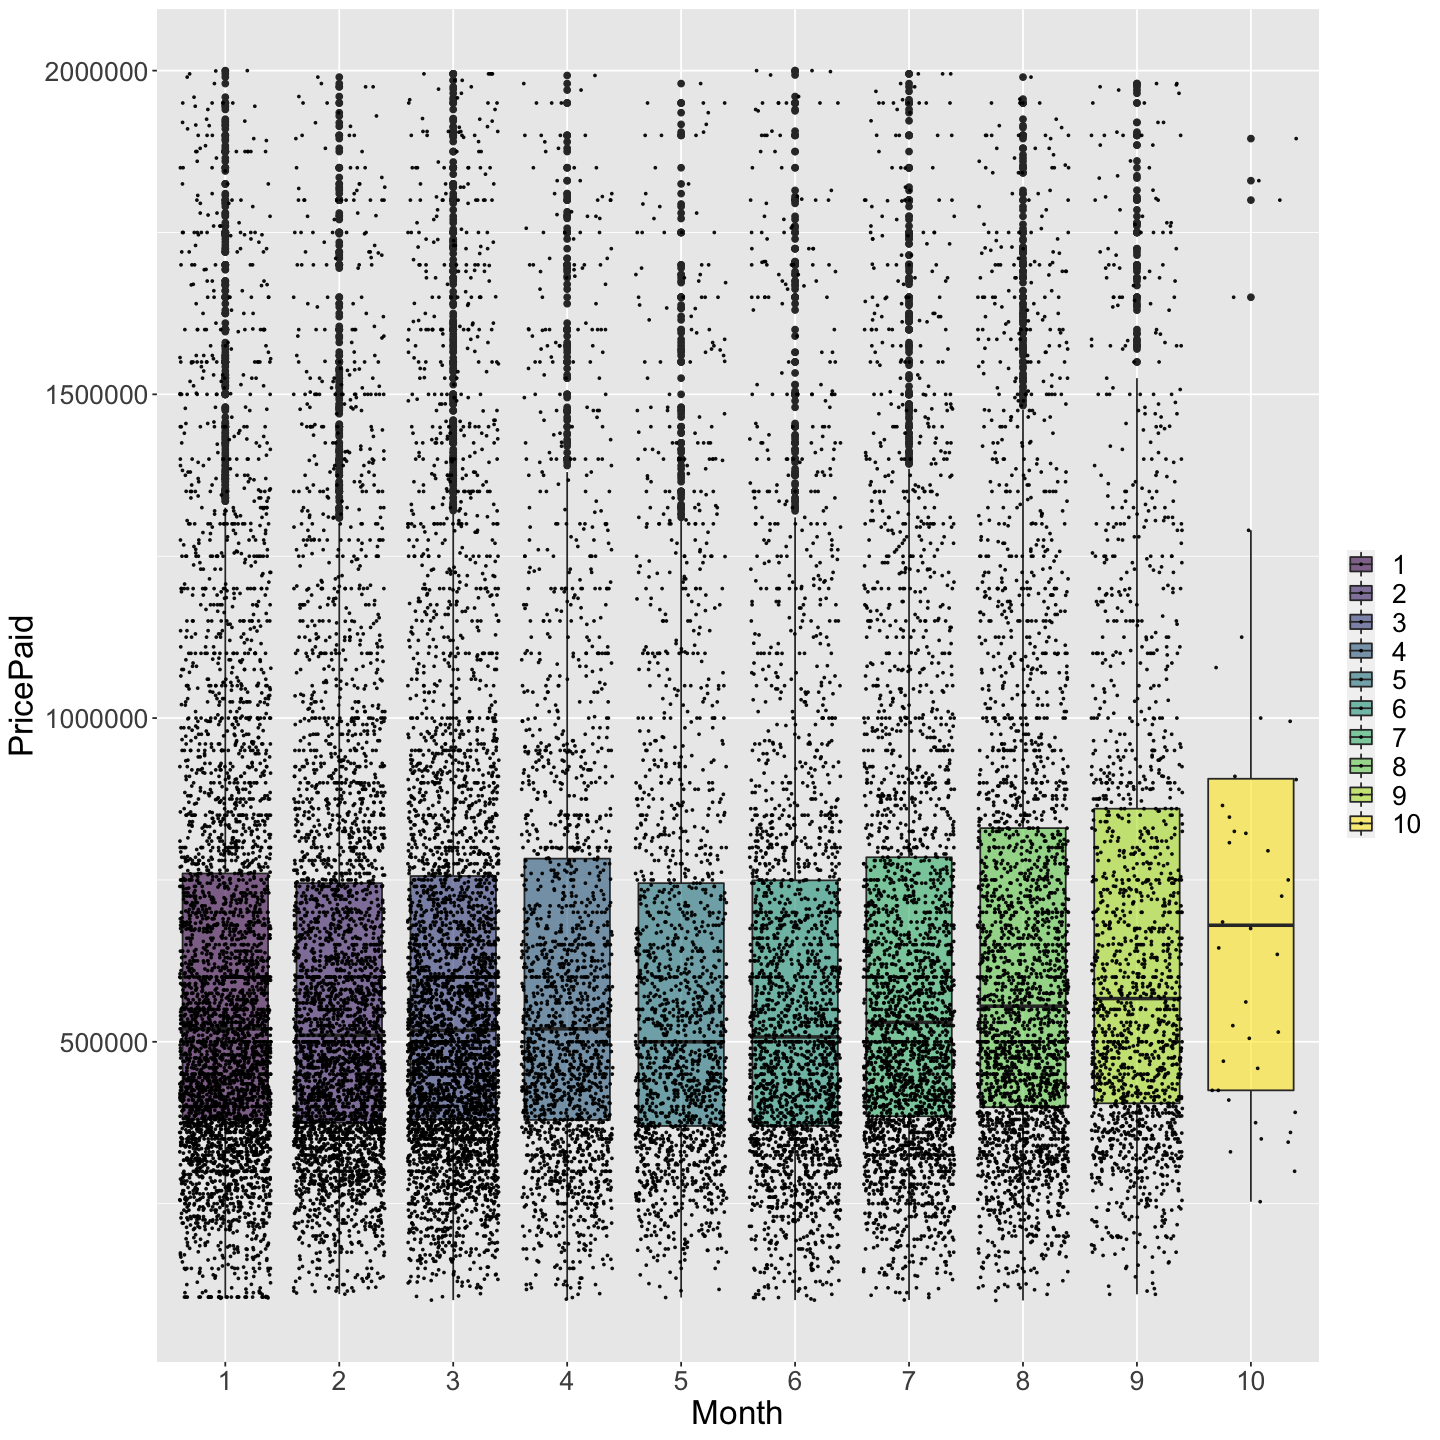

In [441]:
df.ldn.tmp.f %>%
  ggplot( aes(x=Month, y=PricePaid, fill=Month)) +
    geom_boxplot() +
    scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(color="black", size=0.4, alpha=0.9) +
    theme(text = element_text(size = 20),legend.title = element_blank()) +
    xlab("Month")

### Recorded number of houses sold in first 10 months
#### Decline in Sept and October suggests a reporting delay


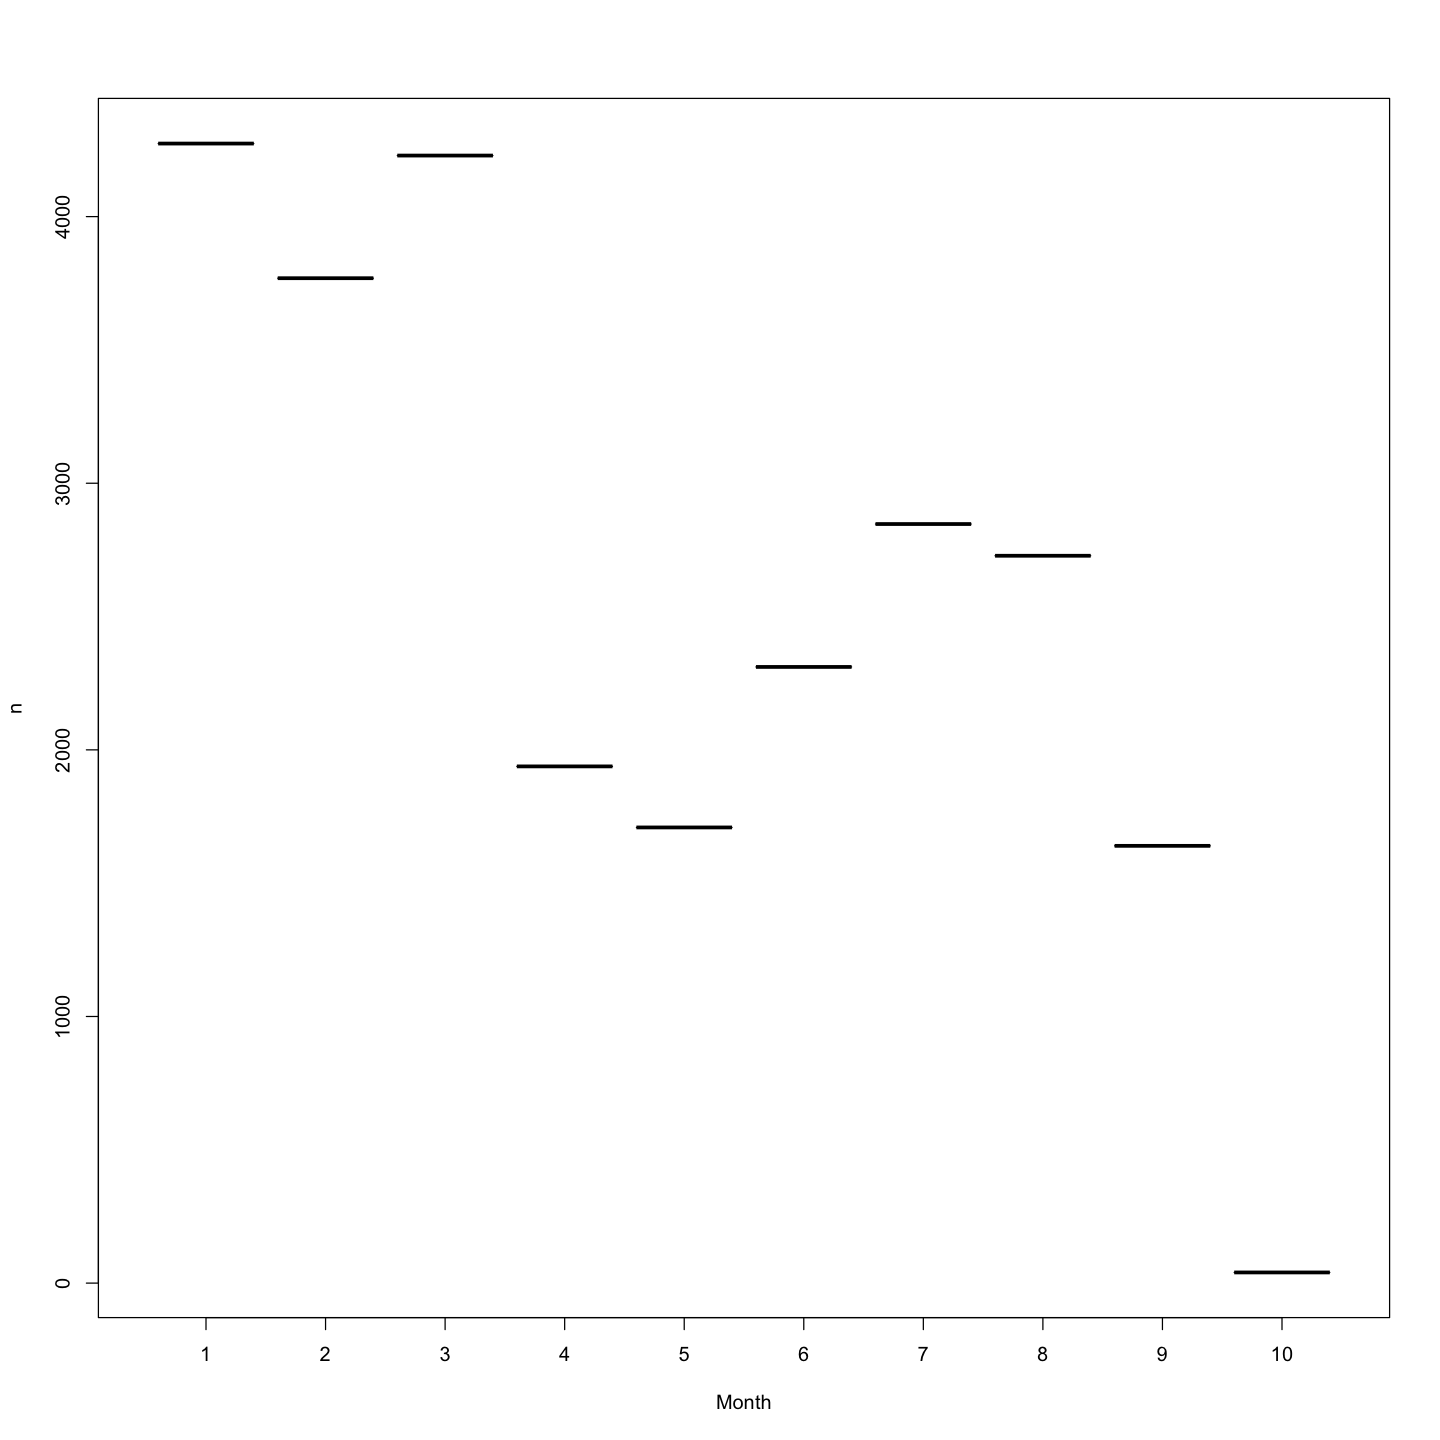

In [442]:
plot(df.ldn.tmp %>% count(Month))

### Linear model

In [444]:

df.ldn.tmp$"Month" <- as.numeric(df.ldn.tmp$"Month") # month as continuous variable
df.ldn.tmp$PricePaid <- df.ldn.tmp$PricePaid/1000000 # consider price in millions

In [445]:
summary(df.ldn.tmp)

   PricePaid          Month       
 Min.   :0.1005   Min.   : 1.000  
 1st Qu.:0.3800   1st Qu.: 2.000  
 Median :0.5250   Median : 4.000  
 Mean   :0.6317   Mean   : 4.378  
 3rd Qu.:0.7750   3rd Qu.: 7.000  
 Max.   :2.0000   Max.   :10.000  

In [446]:
get_prior(PricePaid ~ 1+ Month,
    data = df.ldn.tmp)

prior                  class     coef  group resp dpar nlpar bound source 
1                        b                                           default
2                        b         Month                             default
3 student_t(3, 0.5, 2.5) Intercept                                   default
4 student_t(3, 0, 2.5)   sigma                                       default

In [498]:
mean(df.ldn.tmp$PricePaid)
sd(df.ldn.tmp$PricePaid)

[1] 0.6316694

[1] 0.3632345

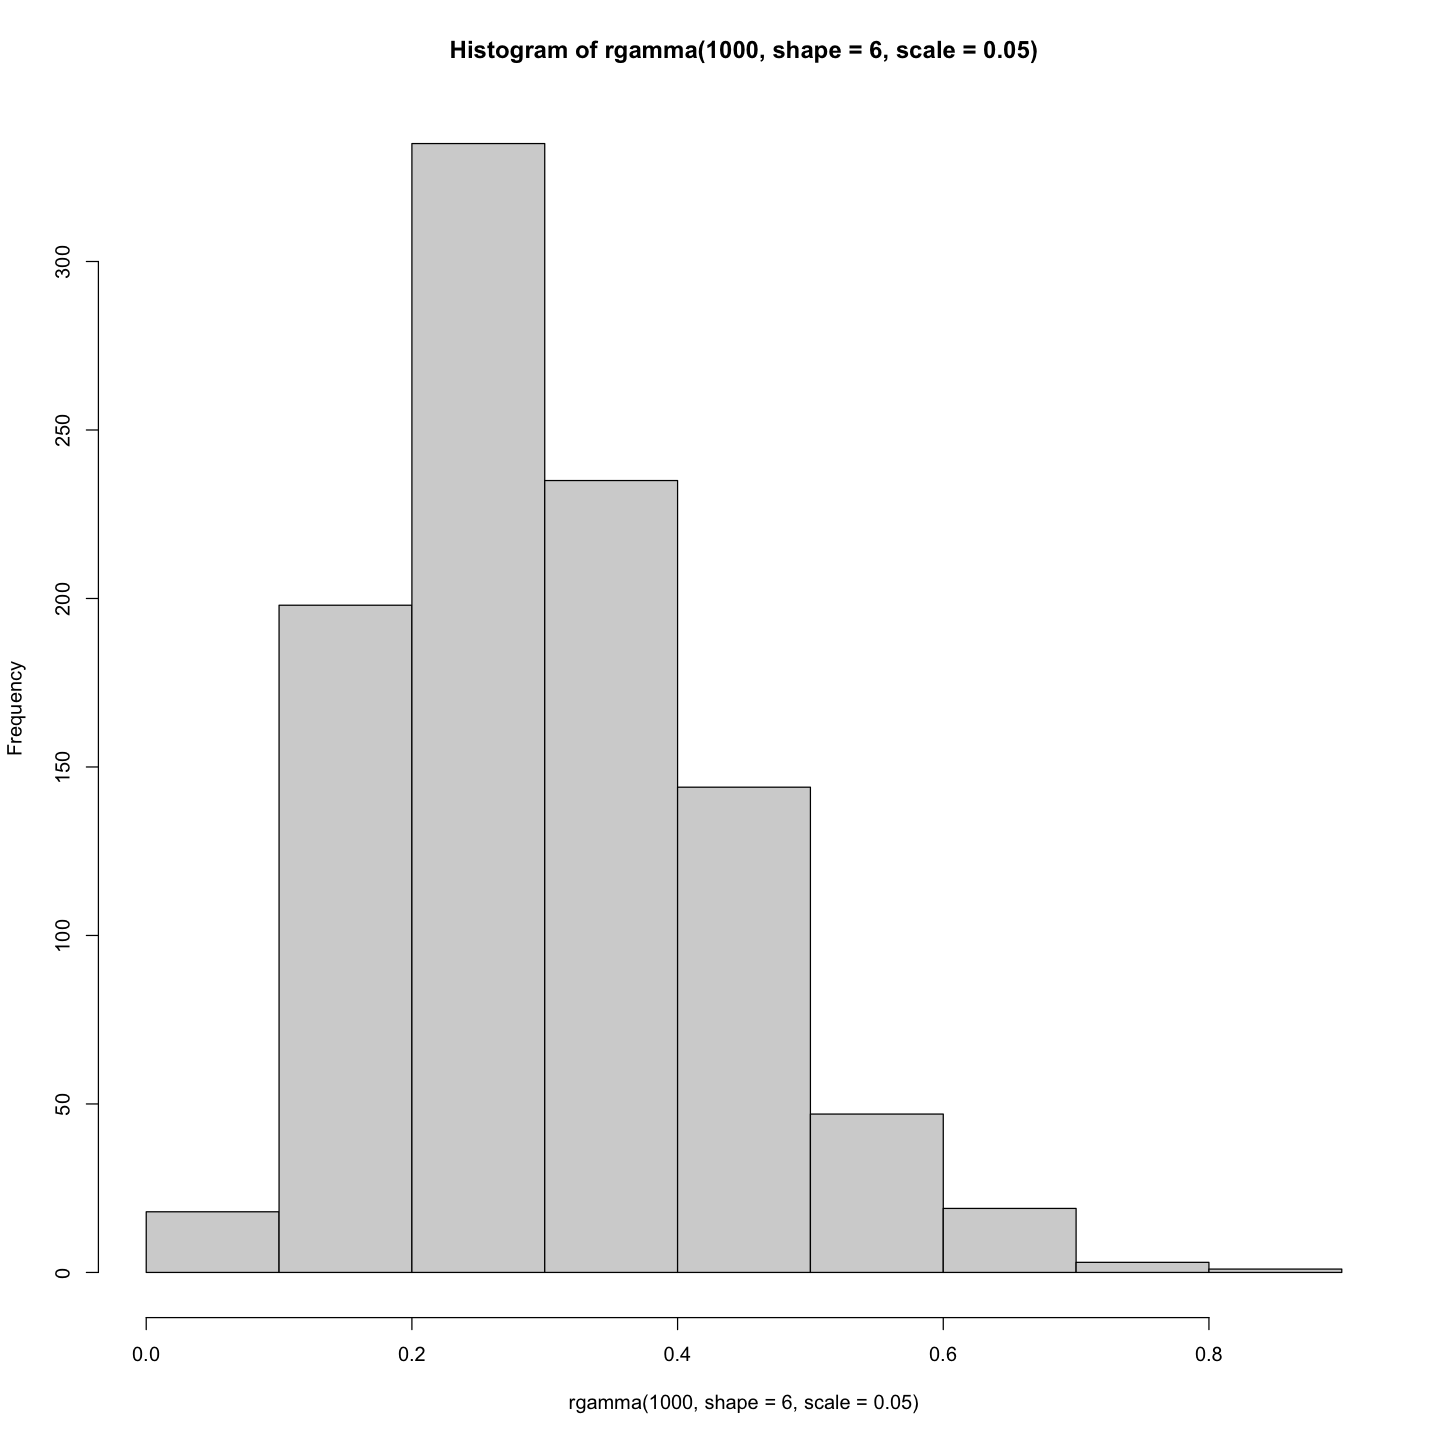

In [588]:
hist(rgamma(1000,shape = 6, scale = 0.05))

In [573]:
priors <- c(prior(normal(0.6, 0.5), class = "Intercept"),
            prior(normal(0,0.1), class = "b"))
#             prior(normal(1,1), class = "sigma"))
fit1 <- brm(
    PricePaid ~ Month,
    data = df.ldn.tmp, 
    family = Gamma(link="linear"),
    prior = priors,
    iter=1000,
    chains = 2,
    cores = 2,
    seed = 123,
    control = list(adapt_delta = 0.9),
    backend = 'cmdstanr',
    refresh = 0
)

ERROR: Error in make.link(link): ‘linear’ link not recognised


In [571]:
summary(fit1)

 Family: gamma 
  Links: mu = inverse; shape = identity 
Formula: PricePaid ~ Month 
   Data: df.ldn.tmp (Number of observations: 25485) 
Samples: 2 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup samples = 1000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.65      0.01     1.63     1.67 1.00      869      746
Month        -0.02      0.00    -0.02    -0.01 1.00     1026      578

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     3.59      0.03     3.53     3.65 1.00      528      449

Samples were drawn using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

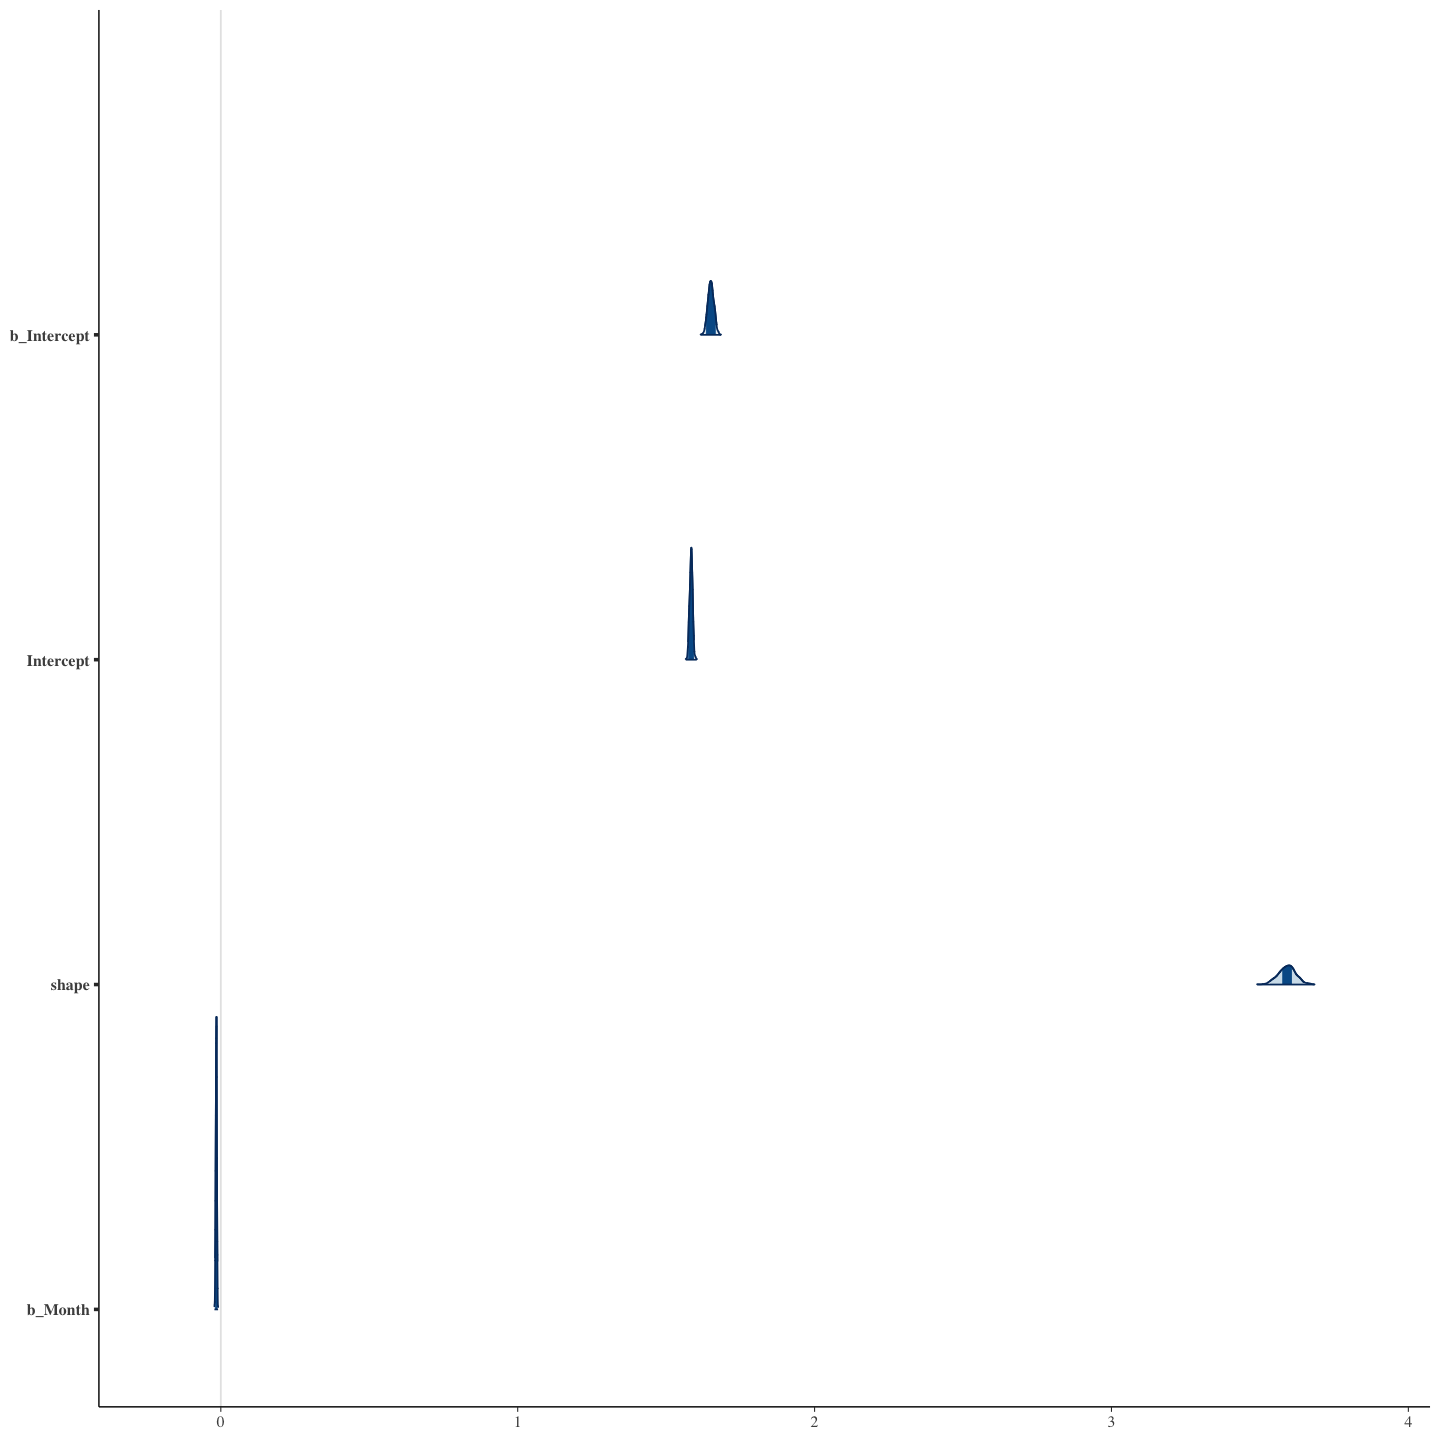

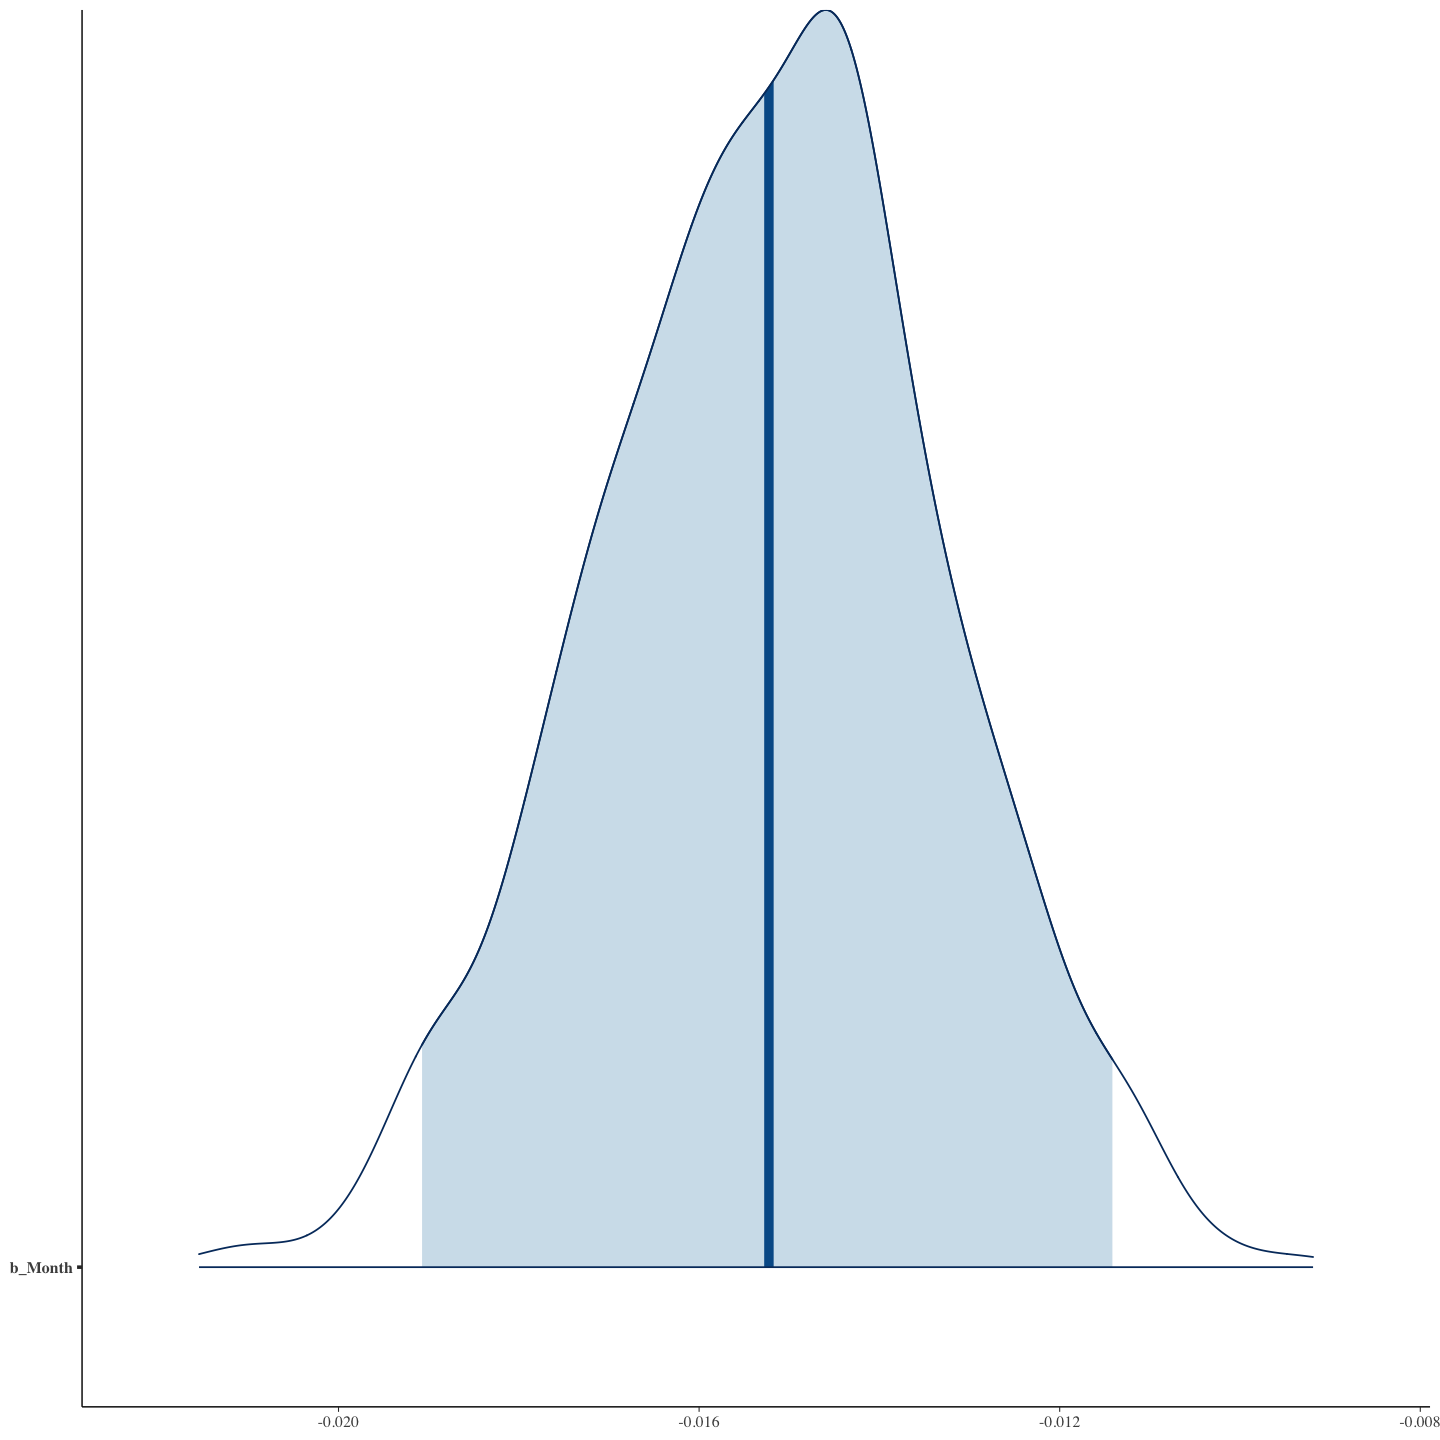

In [572]:
fit.tmp <- fit1
posterior.tmp <- as.matrix(fit.tmp)
mcmc_areas(posterior.tmp,
           regex_pars = c('Inter','shape','scale','b'),
           point_est = "mean",
           prob = 0.95)

mcmc_areas(posterior.tmp,
           pars = c('b_Month'),
           point_est = "mean",
           prob = 0.95) 

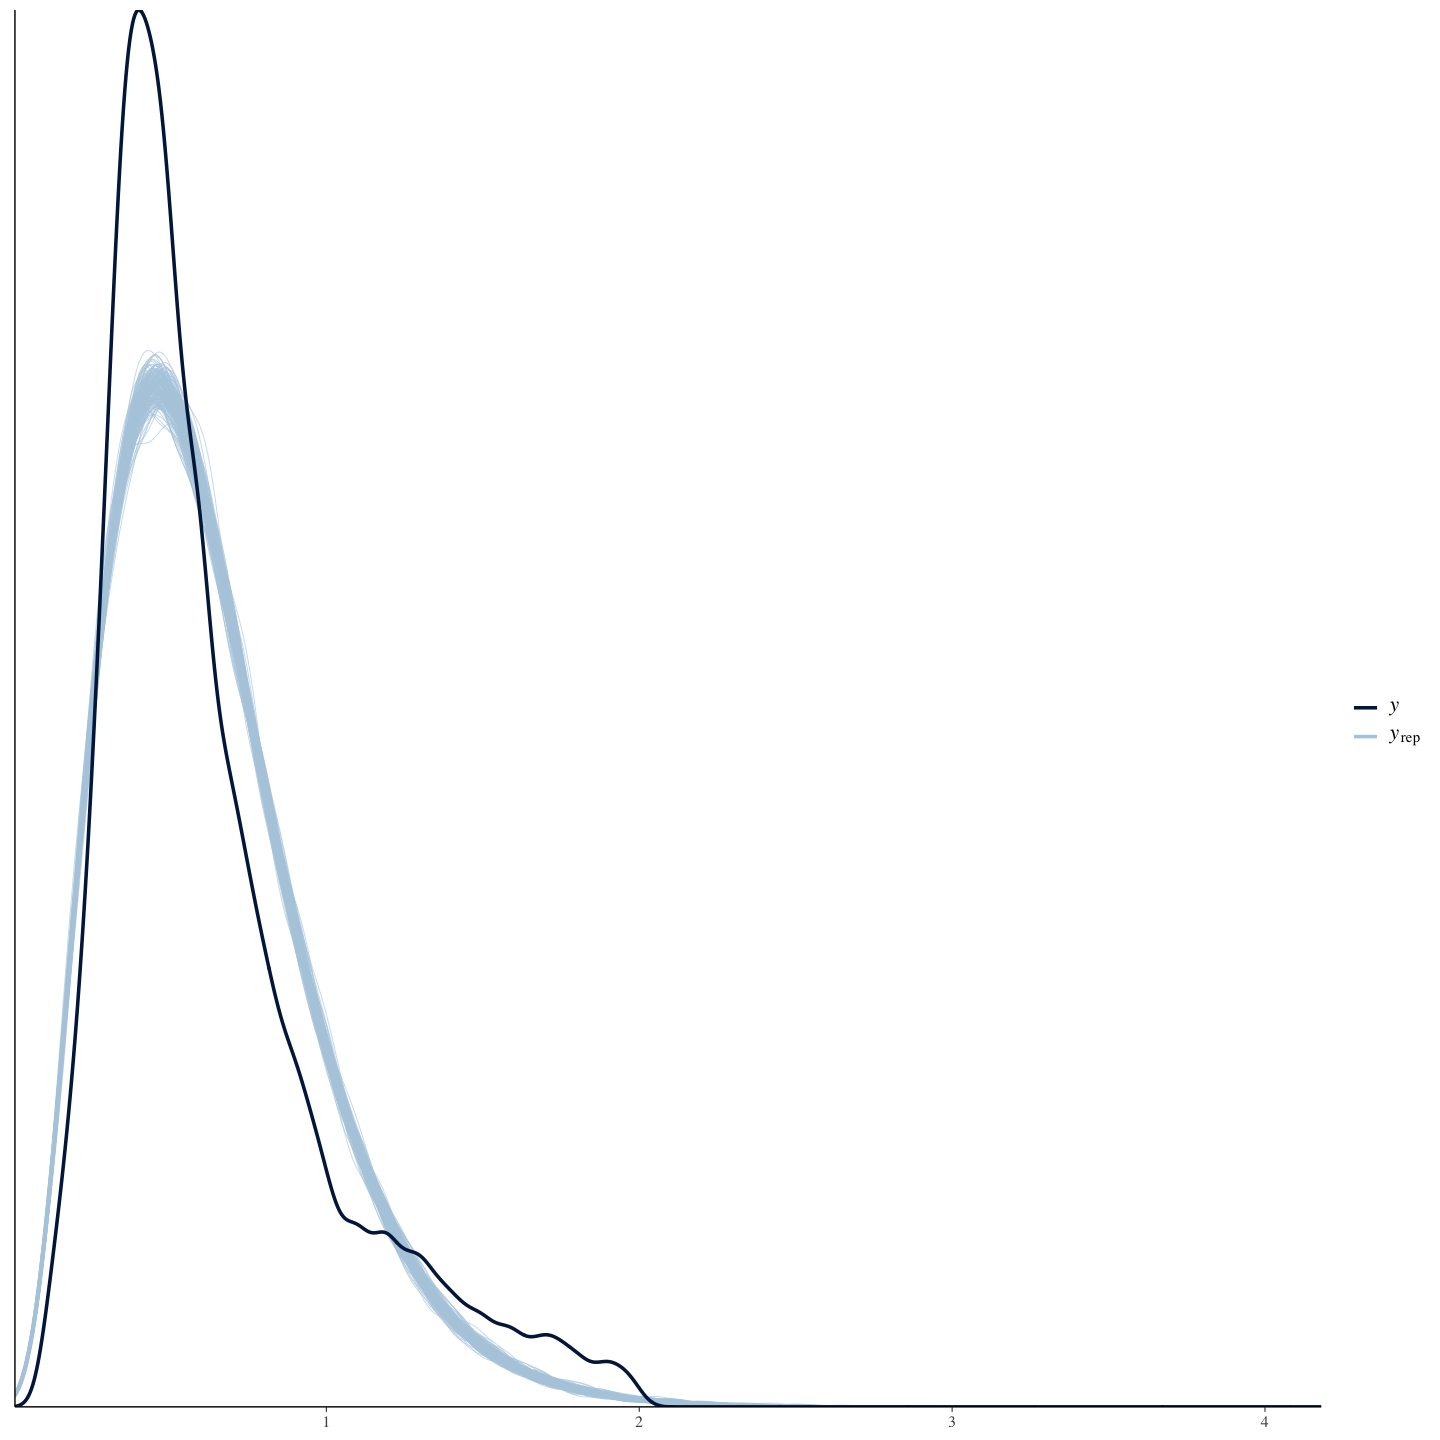

In [516]:
pp_check(fit1,nsamples = 200)

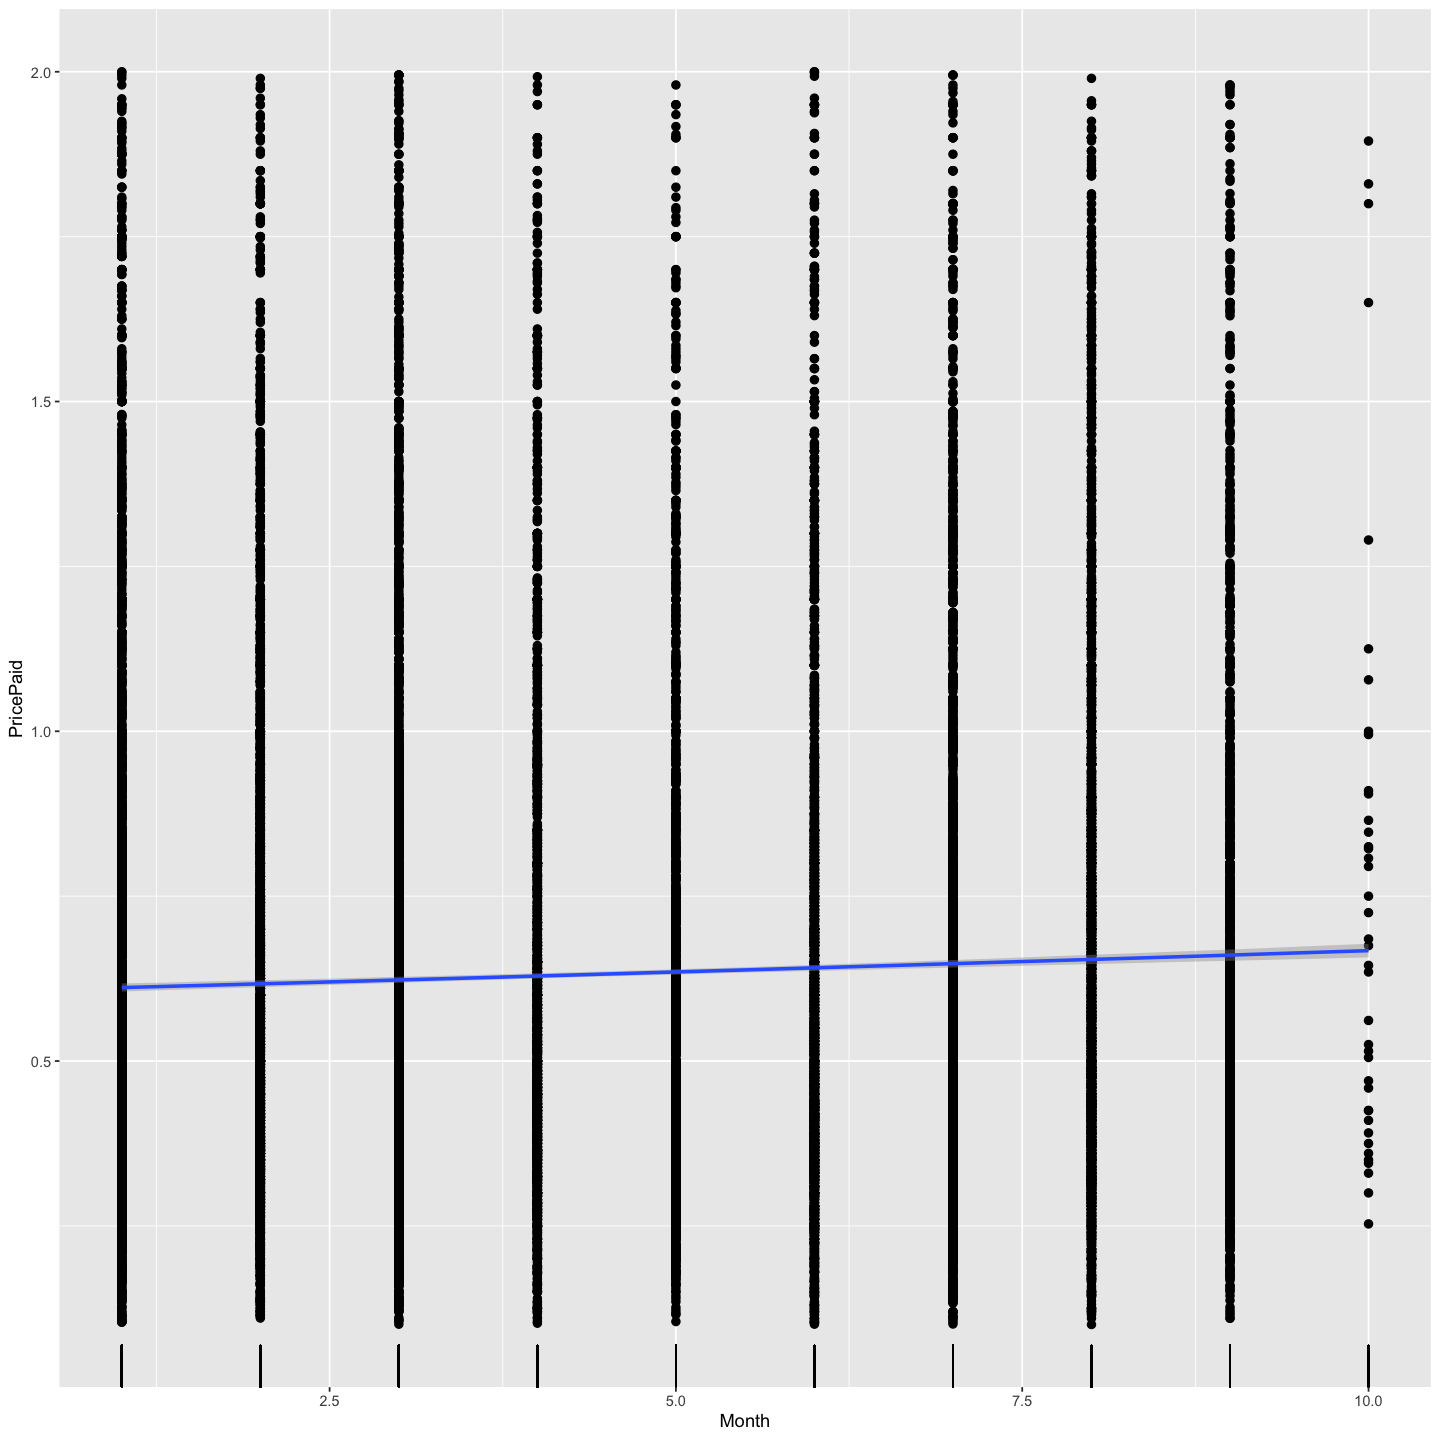

In [517]:
plot(conditional_effects(fit1,effects="Month"),points = TRUE, rug = TRUE) 

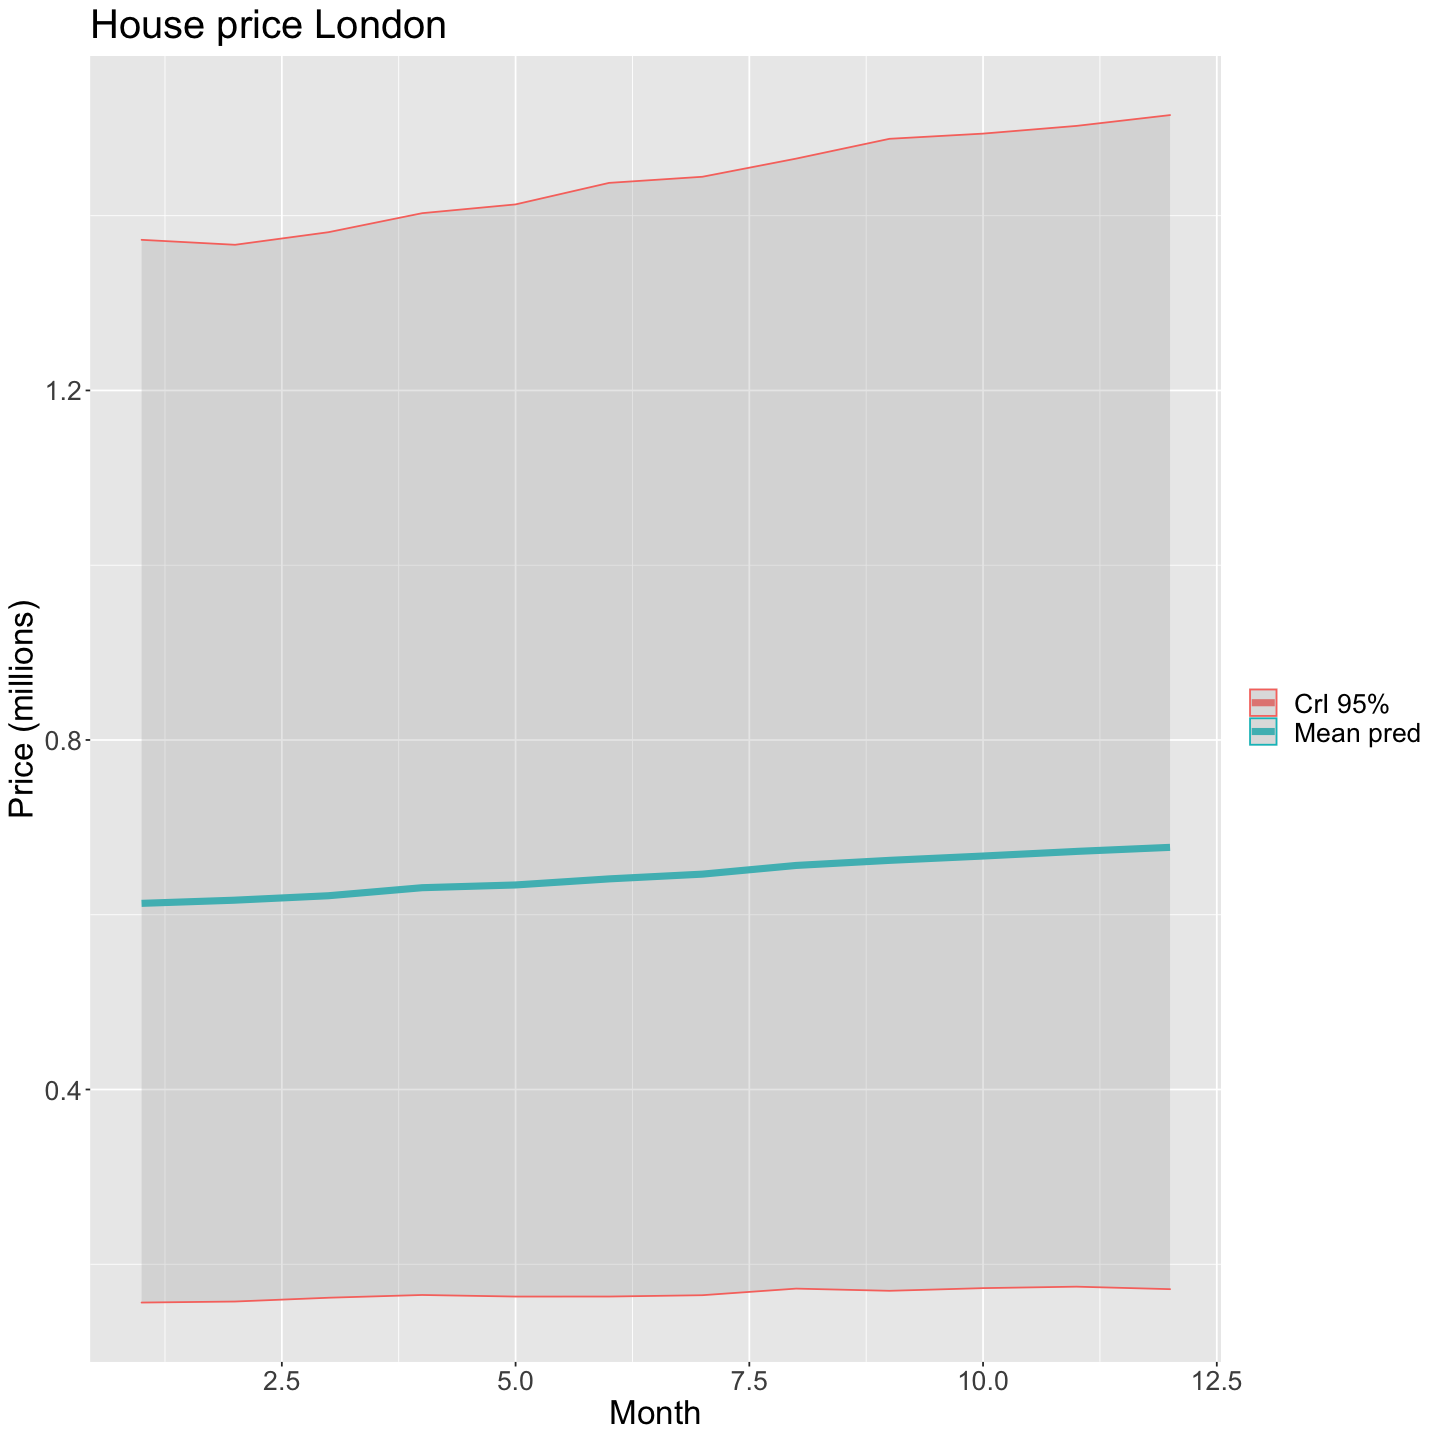

In [568]:
newdata <- data.frame("Month" = rep(seq(1,12),200))
preds <- predict(fit1, newdata = newdata,nsamples = 200)
preds_df = data.frame(preds)
preds_df <- bind_cols(newdata,preds_df)
preds_df <- aggregate(.~Month,data=preds_df,FUN=mean)

ggplot(preds_df, aes(x=Month)) + 
    geom_line(aes(y=Estimate, col="Mean pred"), size = 2) +
    geom_ribbon(
        aes(ymin = Q2.5, ymax = Q97.5, col="CrI 95%"), fill = "grey70", alpha = 0.3)  +
    theme(text = element_text(size = 20),legend.title = element_blank()) +
    xlab("Month") + ylab("Price (millions)") +  ggtitle("House price London")

### Non-linear model

In [391]:
get_prior(PricePaid ~ 1 + s(Month),
    data = df.ldn.tmp)

prior                  class     coef     group resp dpar nlpar bound source 
1                        b                                              default
2                        b         sMonth_1                             default
3 student_t(3, 0.5, 2.5) Intercept                                      default
4 student_t(3, 0, 2.5)   sds                                            default
5                        sds       s(Month)                             default
6 student_t(3, 0, 2.5)   sigma                                          default

In [524]:
priors <- c(prior(normal(0.5,0.5), class = "Intercept"),
            prior(normal(0,0.1), class = "b"))
fit2 <- brm(
    PricePaid ~ 1 + s(Month),
    data = df.ldn.tmp, 
    prior = priors,
    family = Gamma,
    iter=1000,
    chains = 2,
    cores = 2,
    seed = 123,
    control = list(adapt_delta = 0.9),
    backend = 'cmdstanr',
    refresh = 0
)

Compiling Stan program...

Start sampling



Running MCMC with 2 parallel chains...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[87] is -0.00227699, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpeCJAh0/model-1a013c167cec.stan', line 43, column 4 to column 40)

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[87] is -0.00227699, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpeCJAh0/model-1a013c167cec.stan', line 43, column 4 to column 40)

Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[1] is -6.14561, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/RtmpeCJAh0/model-1a013c167cec.stan', line 43, column 4 to column 40)

Chain 1 Exception: gamma_lpdf: Inverse scale parameter[1] is -6.14561, but must be positive finite! (in '/var/fo

Chain 1 finished in 420.5 seconds.
Chain 2 finished in 438.1 seconds.

Both chains finished successfully.
Mean chain execution time: 429.3 seconds.
Total execution time: 438.6 seconds.



This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 




In [525]:
summary(fit2)

 Family: gamma 
  Links: mu = inverse; shape = identity 
Formula: PricePaid ~ 1 + s(Month) 
   Data: df.ldn.tmp (Number of observations: 25485) 
Samples: 2 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup samples = 1000

Smooth Terms: 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sMonth_1)     0.69      0.29     0.27     1.38 1.01      384      567

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.58      0.01     1.57     1.60 1.00     1754      712
sMonth_1     -0.01      0.10    -0.20     0.18 1.01      803      547

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     3.60      0.03     3.54     3.66 1.00     2001      569

Samples were drawn using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (

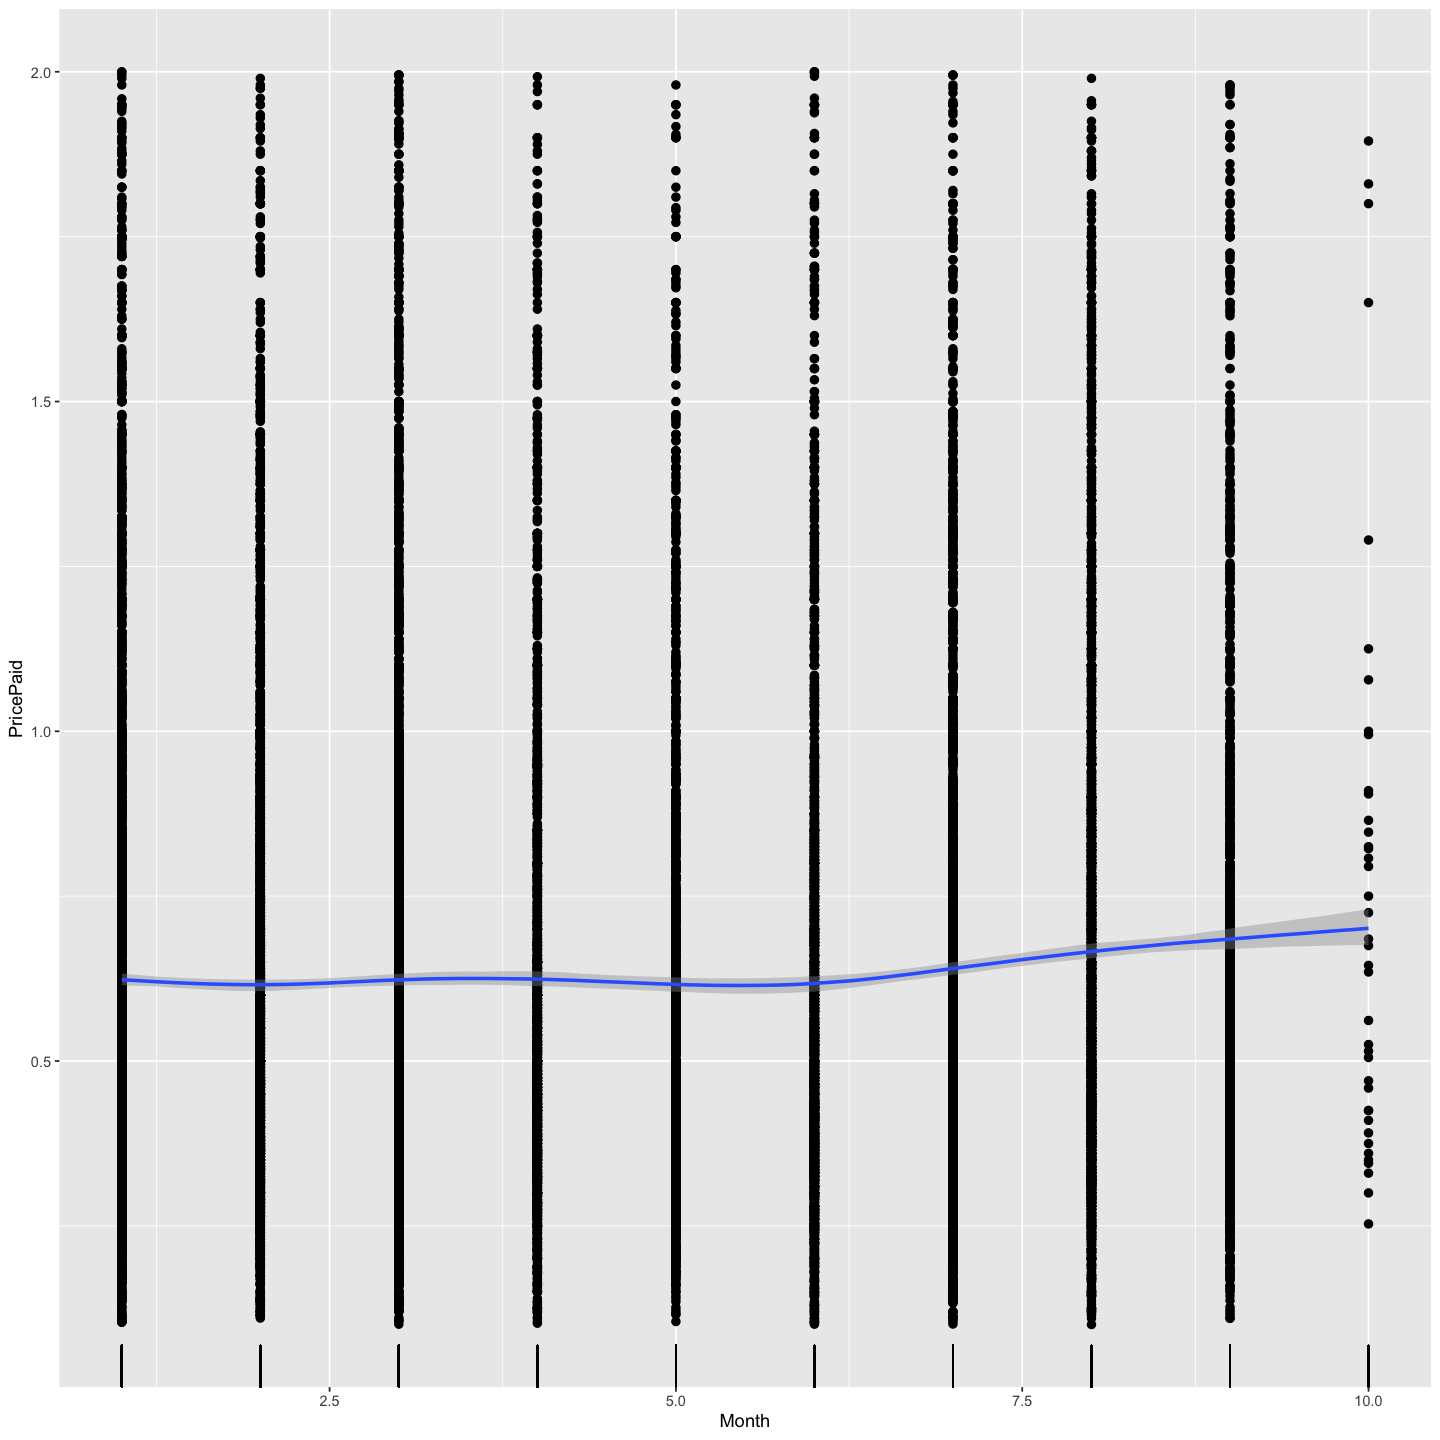

In [528]:
plot(conditional_effects(fit2,effects="Month"),points = TRUE, rug = TRUE)

In [ ]:
ggplot() + 
geom_line(data=Data1, aes(x=A, y=B), color='green') + 
geom_line(data=Data2, aes(x=C, y=D), color='red')

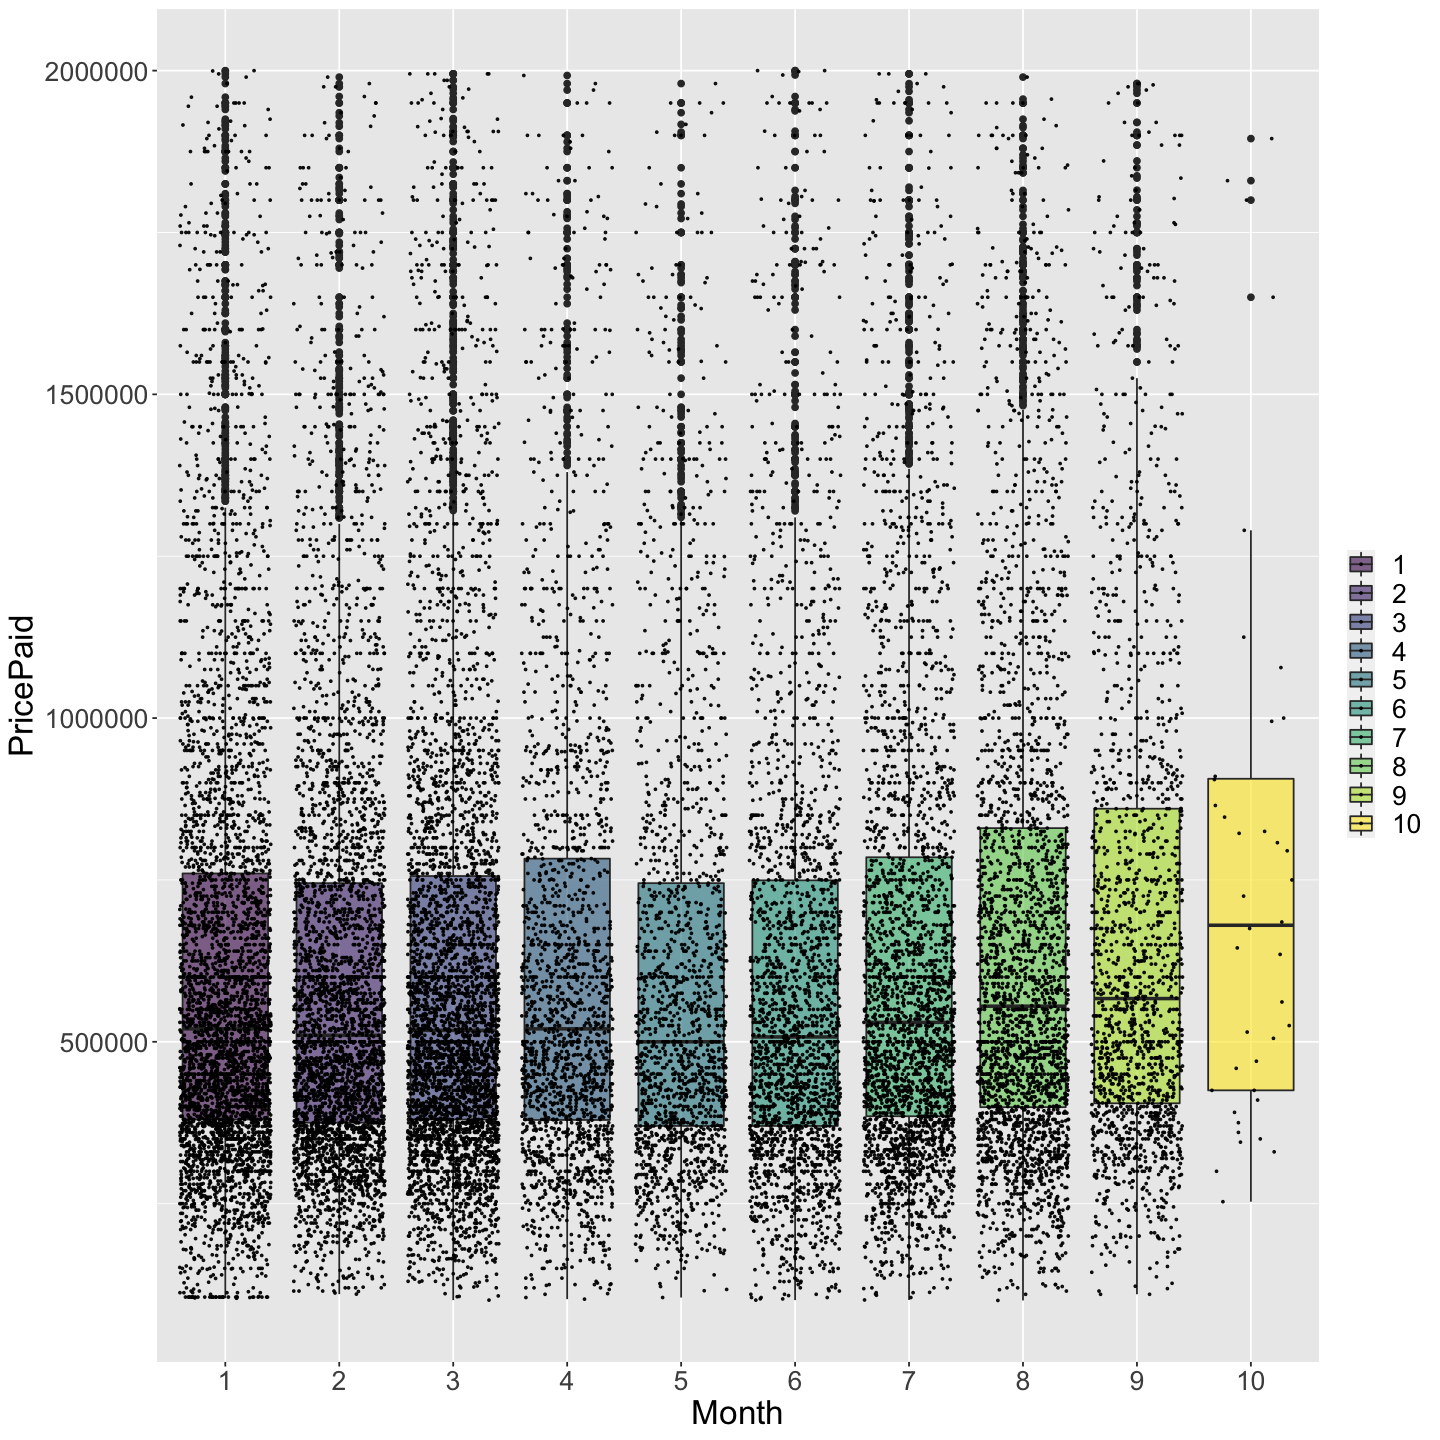

In [615]:
df.ldn.tmp.f %>%
  ggplot( aes(x=Month, y=PricePaid, fill=Month)) +
    geom_boxplot() +
    scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(color="black", size=0.4, alpha=0.9) +
    theme(text = element_text(size = 20),legend.title = element_blank()) +
    xlab("Month")

In [775]:
summary(df.ldn.tmp.f)

   PricePaid           Month     
 Min.   : 100500   1      :4274  
 1st Qu.: 380000   3      :4229  
 Median : 525000   2      :3769  
 Mean   : 631669   7      :2847  
 3rd Qu.: 775000   8      :2728  
 Max.   :1999999   6      :2311  
                   (Other):5327  

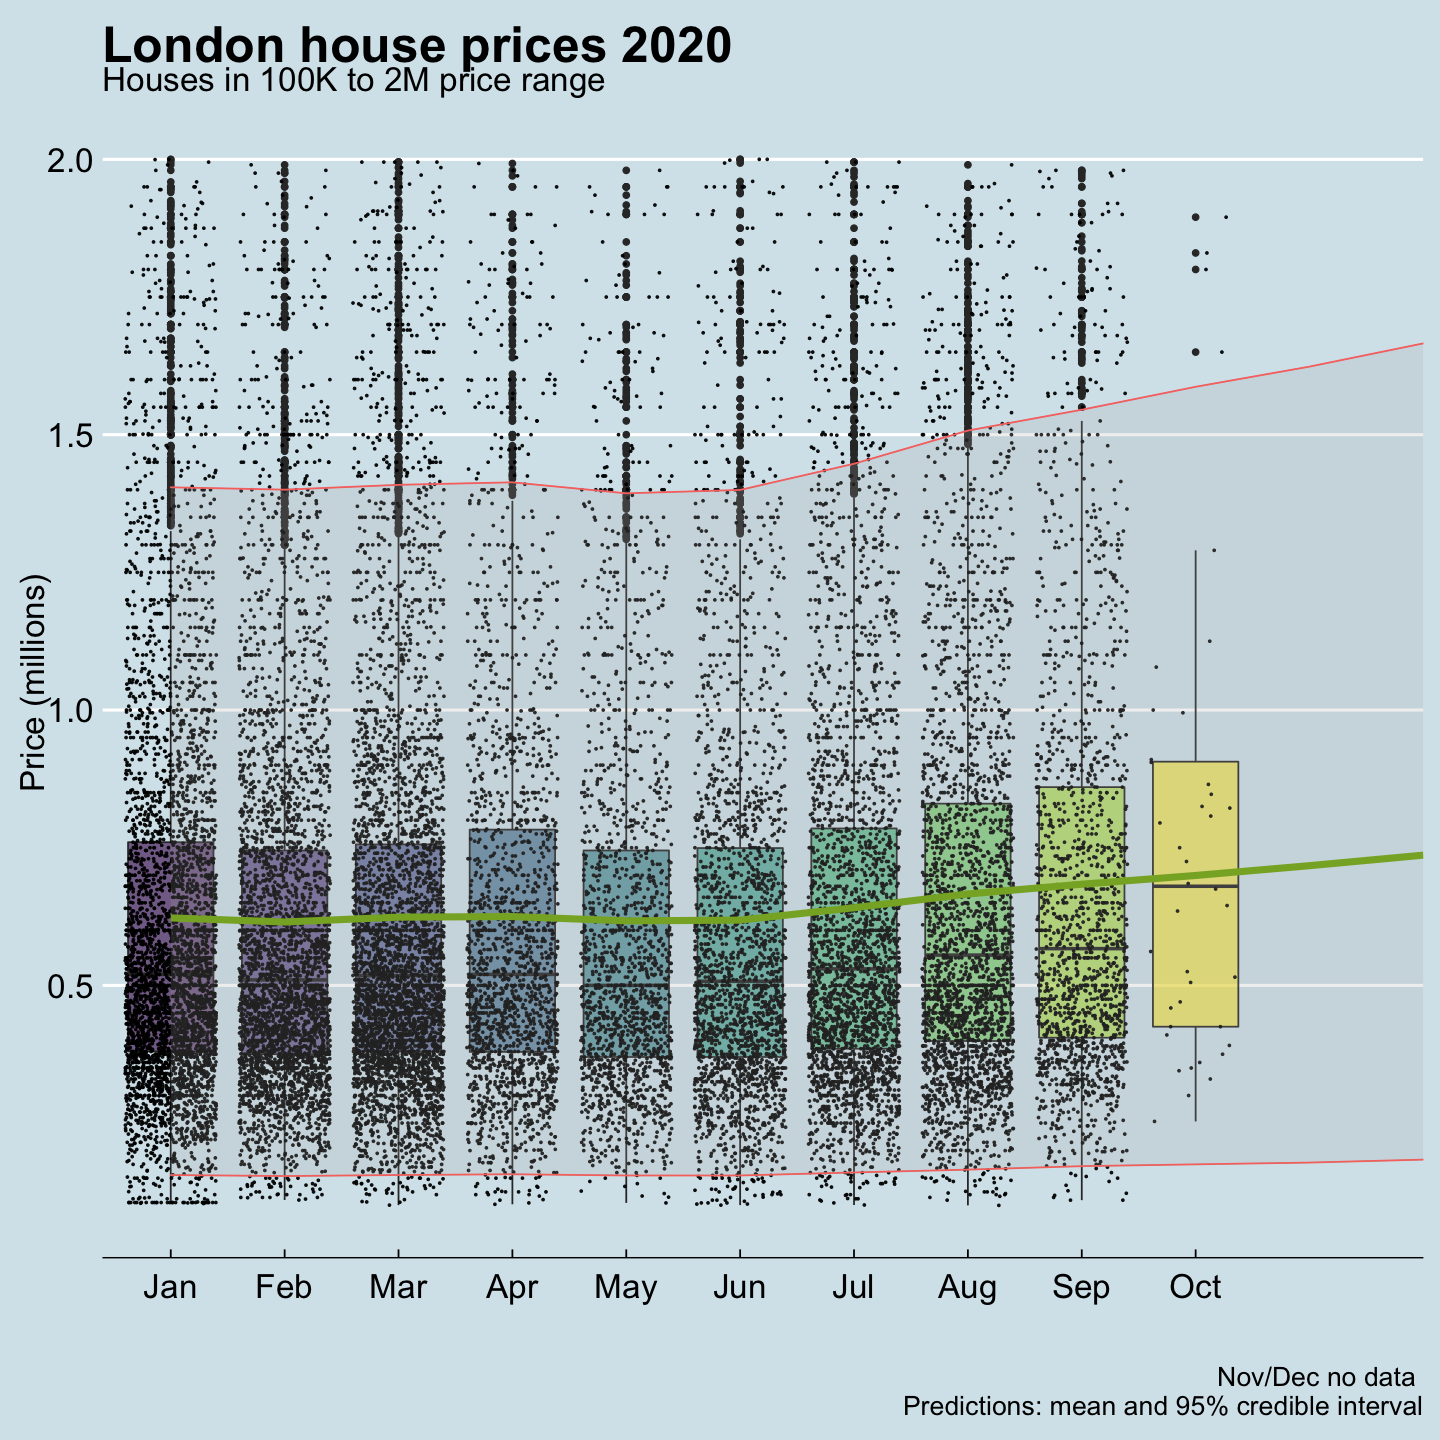

In [847]:
newdata <- data.frame("Month" = rep(seq(1,12),100))
preds2 <- predict(fit2, newdata = newdata)
preds_df2 = data.frame(preds2)
preds_df2 <- bind_cols(newdata,preds_df2)

preds_df2 <- aggregate(.~Month,data=preds_df2,FUN=mean)


  ggplot() +
    theme_economist() + 
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")) +
    theme(legend.position="none") +
    xlab("Month") + ylab("Price (millions)") +  
    labs(title = "London house prices 2020",
        subtitle = "Houses in 100K to 2M price range",
        caption ="\nNov/Dec no data \nPredictions: mean and 95% credible interval") +
    
    geom_boxplot(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid/1000000, fill=Month)) +
    scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid/1000000),color="black", size=0.4, alpha=0.9) +
    theme(text = element_text(size = 20),legend.title = element_blank()) +
    geom_line(data = preds_df2, aes(y=Estimate, x=Month, col="Mean pred"), size = 2) +
    geom_line(data = preds_df2,aes(y=Q2.5, x=Month,col="Q2.5"), size = 0.2) +
    geom_line(data = preds_df2,aes(y=Q97.5, x=Month,col="Q97.5"), size = 0.2) +
    geom_ribbon(data = preds_df2,
        aes(ymin = Q2.5, ymax = Q97.5,x=Month, col="CrI 95%"), fill = "grey70", alpha = 0.2)  +
    theme(text = element_text(size = 20),legend.title = element_blank()) + 
    xlab("") 

In [851]:
newdata <- data.frame("Month" = rep(seq(1,12),100))
preds2 <- predict(fit2, newdata = newdata,nsamples = 200)
preds2 = data.frame(preds2)
preds2 <- bind_cols(newdata,preds2)

preds2$sd_lower = preds2$Estimate - (preds2$Estimate - preds2$Q2.5)/sqrt(length(preds2$Estimate))
preds2$sd_upper = preds2$Estimate + ( preds2$Q97.5 -preds2$Estimate)/sqrt(length(preds2$Estimate))

preds_df2 <- aggregate(.~Month,data=preds2,FUN=mean)

In [852]:
df_grow = data.frame("Month" = preds_df2$"Month",
                     "Growth" = 100*(preds_df2$Estimate - preds_df2$Estimate[1])/preds_df2$Estimate[1],
                    "G_up" = 100*(preds_df2$sd_upper - preds_df2$Estimate[1])/preds_df2$Estimate[1],
                    "G_low" = 100*(preds_df2$sd_lower - preds_df2$Estimate[1])/preds_df2$Estimate[1])

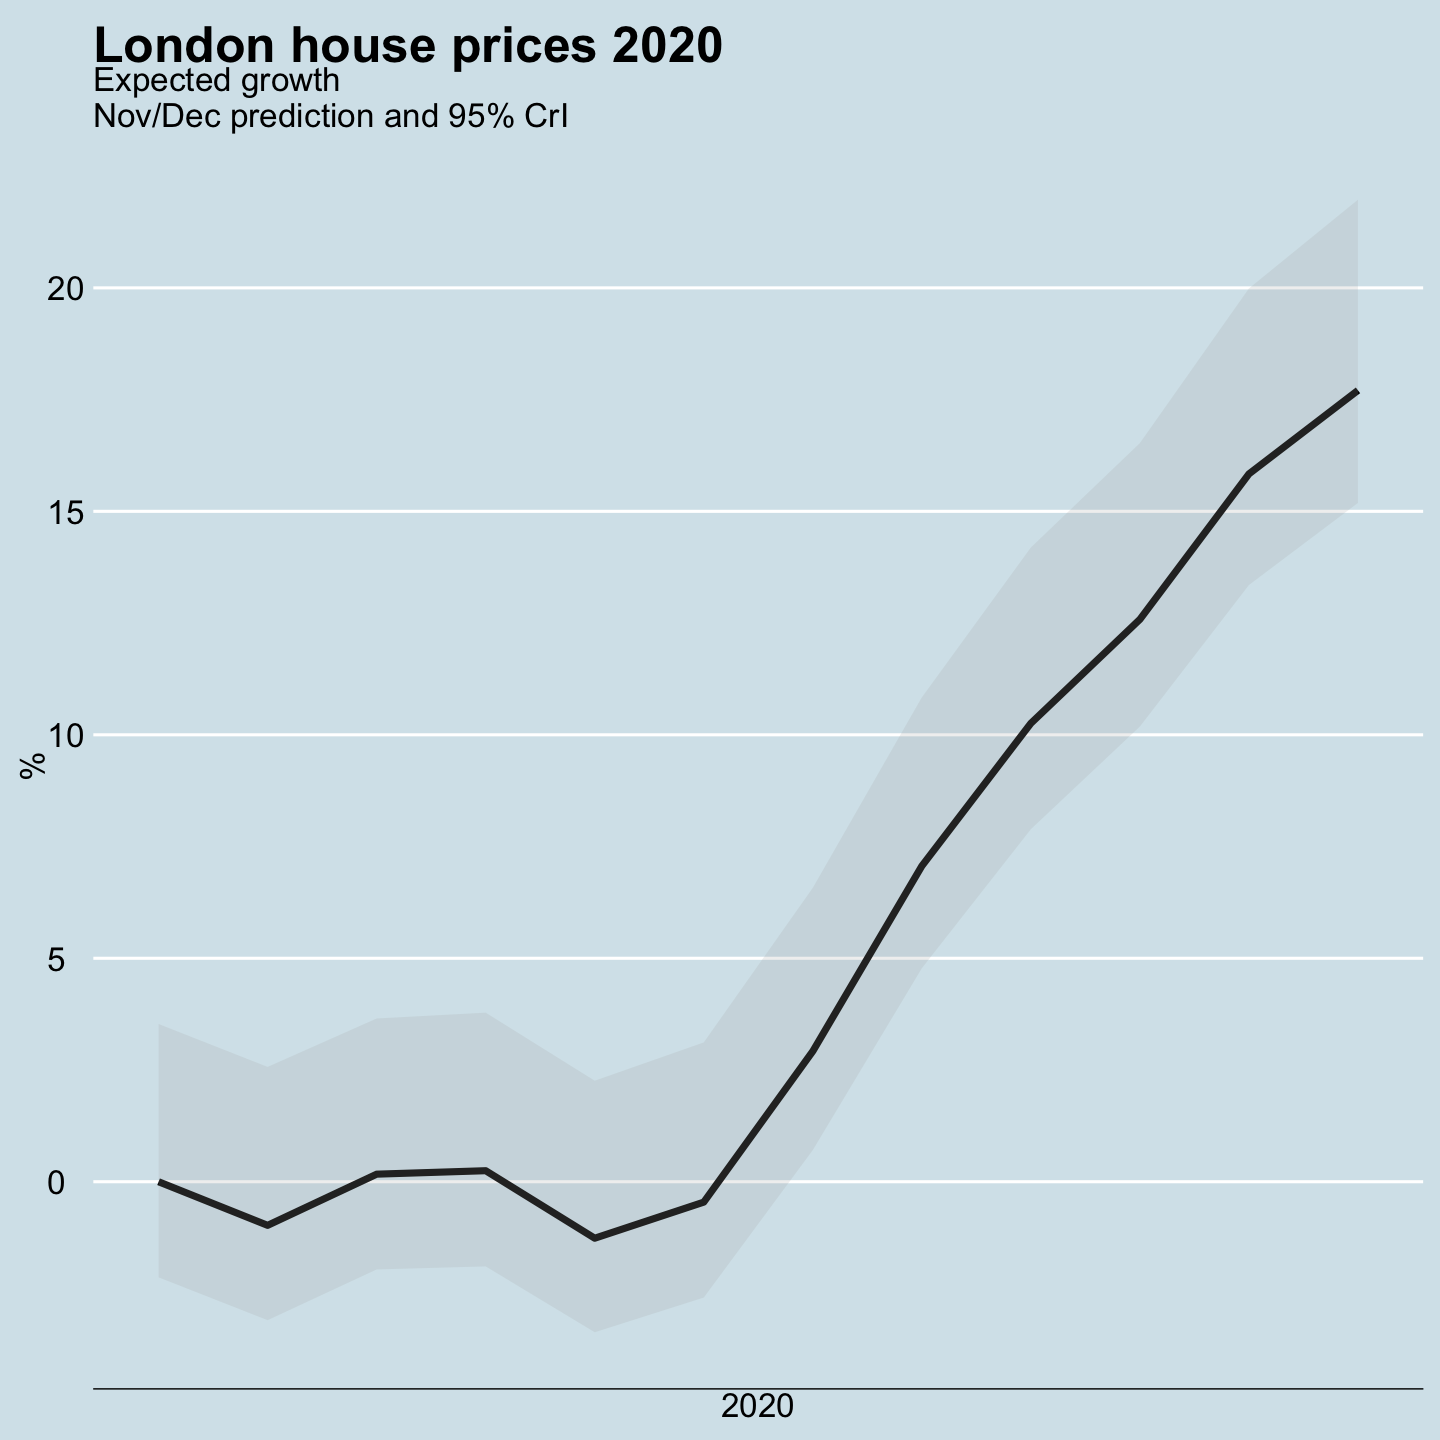

In [853]:
df_grow %>% ggplot() + geom_line(aes(x = Month, y = Growth),size = 2) +
     geom_ribbon(aes(ymin = G_low, ymax = G_up, x=Month), fill = "grey70", alpha = 0.2) +
    theme_economist() + 
    theme(legend.position="none") +
    ylab("%")  +
    labs(title = "London house prices 2020",
              subtitle = "Estimated change \nNov/Dec prediction and 95% CrI") +
    theme(text = element_text(size = 20),legend.title = element_blank())  + xlab("2020") +
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"))